# Opdracht 3

Natasja de Kok		22059326 

Tim Oosterling		22078800 

Rogier Gernaat		22100385 


# Inleiding en opdrachtsomschrijving

Bij deze opdracht kijken wij of machine learning in staat is om verschillende muziekgenres van elkaar te onderscheiden. Een reden die wij kunnen bedenken voor deze opdracht is dat muziek weleens wordt gezien als één van de geneugtes van het leven. Maar waar de ene muziekliefhebber van rock houdt, houdt de andere juist van klassieke muziek. Of van jazz. Of van andere soorten muziek. Of van meerdere genres. Het genre doet er dus toe voor mensen. Met behulp van het model dat wij hiermee maken kunnen wij potentieel andere mensen helpen met het onderscheiden van een paar genres. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lr
from IPython.display import Audio
import os 
import whisper
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import re
from sklearn.metrics import accuracy_score

pd.set_option('display.max_colwidth', None)


## Audiolengte normaliseren
Hieronder laden we de audiofiles in en normaliseren we ze qua lengte door ze 30 seconden lang te maken.
Alhoewel de standaardrate 44100 Hz is (Wikipedia. (z.d.)), gebruiken wij hieronder de rate 22050. Dat is een sample rate dat vroeger redelijk populair was als 64 kbps voor MP3-formaat (Audacity Team. (z.d.).)


In [85]:
SECONDS = 30
SAMPLE_FREQUENCY = 22050

# base_dir = r"C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled"  NKOK uitgecommend voor eigen
#base_dir = r"C:\Users\rogie\ADS-AI Jaar 2\Machine Learning\Portfolio 3\unlabeled"
base_dir = r"C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled"
print(f"base_dir is ingesteld op: {base_dir}")

# Lists voor audio data
audio_data = []
sample_freqs = []
wav_names = []

# Target length instellen van de audio clip, Hierbij willen we de volledige 30 seconden
# De HZ kun je vinden in sfreq
target_length = SAMPLE_FREQUENCY * SECONDS


# Process elke audio file 
for file in os.listdir(base_dir):
    if file.endswith(".wav"):
        file_path = os.path.join(base_dir, file)
        data, sfreq = lr.load(file_path, sr=None) 

        wav_names.append(file)
        
        # Truncate or pad the audio
        if len(data) > target_length:
            # Truncate the data
            data = data[:target_length]
        elif len(data) < target_length:
            # Pad with zeros
            padding = target_length - len(data)
            data = np.pad(data, (0, padding), mode='constant')

        # Append de data
        audio_data.append(data)
        sample_freqs.append(sfreq)

# Omzetten naar een numpy array
audio_data = np.stack(audio_data, axis=0)
sample_freqs = np.array(sample_freqs)

# Laat een voorbeeld zien
print(audio_data[:5])


base_dir is ingesteld op: C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled
[[-0.12936401 -0.14221191 -0.11578369 ...  0.0255127   0.01348877
  -0.06192017]
 [-0.0038147   0.08908081  0.16000366 ... -0.04455566 -0.206604
  -0.3164673 ]
 [ 0.00479126  0.00488281  0.0045166  ... -0.00674438 -0.00491333
  -0.00311279]
 [-0.11505127 -0.12127686 -0.13723755 ...  0.15475464  0.07391357
  -0.07192993]
 [-0.01782227 -0.01669312 -0.01486206 ...  0.00323486  0.00390625
   0.0045166 ]]


We experimenteren hieronder met de audio_data. Dat doen we door een willekeurige audio_file te selecteren en af te spelen.

In [86]:
random_index = np.random.choice(len(audio_data), size=1, replace=False)
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]

#show name
print(wav_names[int(random_index)])

# Play the clip
Audio(data=clip, rate=sfreq)

m00515.wav


C:\Users\KaasT\AppData\Local\Temp\ipykernel_13800\1809163275.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(wav_names[int(random_index)])


## Labeled data normaliseren
Hieronder worden de gelabelde audio-fragmenten ingeladen en weer genormaliseerd op 30 seconden. Met behulp van gelabelde data kunnen we het model trainen, omdat hierbij de juiste targetwaarden voor handen zijn en steeds kan worden gekeken hoe goed het model presteert.

In [4]:
# Base_dir: dit is waar mijn labeled data staat
#base_dir_l = r"C:\Users\rogie\ADS-AI Jaar 2\Machine Learning\Portfolio 3\labeled"
base_dir_l = r"C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\labeled"
labels = pd.read_csv('labels.csv', sep=',')

# Lists voor audio data
audio_data_l = []
sample_freqs_l = []
wav_names_l = []

# Target length instellen van de audio clip, Hierbij willen we de volledige 30 seconden
# De HZ kun je vinden in sfreq
target_length = SECONDS * SAMPLE_FREQUENCY


# Process elke audio file 
for file in os.listdir(base_dir_l):
    if file.endswith(".wav"):
        file_path = os.path.join(base_dir_l, file)
        data, sfreq = lr.load(file_path, sr=None) 

        wav_names_l.append(file)
        
        # Truncate or pad the audio
        if len(data) > target_length:
            # Truncate the data
            data = data[:target_length]
        elif len(data) < target_length:
            # Pad with zeros
            padding = target_length - len(data)
            data = np.pad(data, (0, padding), mode='constant')

        # Append de data
        audio_data_l.append(data)
        sample_freqs_l.append(sfreq)
        
# Labels sorteteren op filename
#https://chat.openai.com/share/16fc1596-18ca-41ad-8602-

labels['numeric_part'] = labels['filename'].apply(lambda x: int(re.search(r'\d+', x).group()))
labels = labels.sort_values('numeric_part')
labels = labels.reset_index(drop=True)
labels.drop('numeric_part', axis=1, inplace=True)
labels.drop([86], inplace = True) 
labels = labels.reset_index(drop=True)

labels = labels.rename(columns={'genre;;;;;;': 'genre'})
labels['genre'] = labels['genre'].str.replace(';', '')

display(labels)





filename   genre
0    m00001.wav   disco
1    m00002.wav    jazz
2    m00005.wav     pop
3    m00006.wav   disco
4    m00007.wav     pop
..          ...     ...
644  m00993.wav  reggae
645  m00994.wav     pop
646  m00996.wav    jazz
647  m00998.wav    rock
648  m00999.wav   blues

[649 rows x 2 columns]

# Features

### Spectrogram
- bron: https://emastered.com/nl/blog/what-is-spectrogram + Chat_GPT

Audio kun je in  meerdere dimensies weergeven. De meest gebruikelijke versie hiervan is de audiogolfvorm (Dit speelt af in 2 dimensies). Bij de audiogolfvorm wordt de "tijd" weergeven op de X-as en de "golfamplitude", die ook wel de luidheid van de audio genoemd wordt, gemeten langs de Y-as.

Deze data wordt getoond door middel van een grafiek voor audio of geluid en op die manier is het mogelijk om de golfvorm tot op een bepaald niveau te kunnen lezen zonder dat je naar de opname zelf hoeft te luisteren.
<div style="display: flex; align-items: flex-start;">
    <img src="Golfvorm.png"  style="margin-left: 10px;">
</div>

Wat een spectrogram onderscheidt van een normale audiogolfvorm is dat de audiografiek die je hierboven ziet een nieuwe dimensie heeft, genaamd "frequentie-inhoud van de audio". Door deze extra informatiebron kun je veel meer lezen over het audiobestand voordat je er überhaupt naar hebt geluisterd.

<div style="display: flex; align-items: flex-start;">
    <img src="Spectrogrammen.png"  style="margin-left: 10px;">
</div>
Om dit te gebruiken als feature bereken we de frequentieverandering over tijd aan de hand van STFT (Short Term Fourier Transform).

Short Term Fourier Transform: Is een verwerkingsalgoritme dat wordt gebruikt om de frequentie-inhoud van audio te analyseren. Dit doet het algoritme door de audio op te splitsen in korte segmenten en per segment de Fourier Transform te berekenen. Dit algoritme wordt gebruikt om op efficiënte wijze de frequentie-inhoud over tijd te analyseren

Hieronder hebben we een functie geprogrammeerd genaamd calculate_spectogram. Deze functie heeft een aantal al ingevulde parameters. Deze betekenen respectievelijk dat het aantal frequentie-bins op 2048 wordt gesteld (Shkhanukova, M. (2022, september 15).), het aantal kolommen van de spectogram op 512 wordt gesteld en er geen sprake is van een window, zodat de vensters gewoon even lang zijn als n_fft (PyTorch. (z.d.). ). Met behulp van de lr.stft-functie (lees er hier meer over: Librosa. (z.d.). ) wordt er een Short-Time Fourier Transform op elk audiofragment berekend en omgezet naar lineaire en decibel-spectogrammen. 
We passen deze functie toe op audio_data en audio_data_1 en slaan de resultaten op. 

In [5]:
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow

def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:

        # Calculate the STFT. Use lr.stft() here.
        stft = lr.stft(clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spec = np.abs(stft)

        # Convert to decibels. Use amplitude_to_db() here.
        spec_db = amplitude_to_db(spec)

        # Append the spectrogram to the list
        spectrograms.append(spec)
        
        # Append spectrogram in decibels to the list
        spectrograms_db.append(spec_db)
        
    return spectrograms, spectrograms_db
# Use function
spectrograms, spectrograms_db = calculate_spectrograms(audio_data, n_fft=2048, hop_length=512, win_length=None)
spectrograms_l, spectrograms_db_l = calculate_spectrograms(audio_data_l, n_fft=2048, hop_length=512, win_length=None)

#### Aansluiting op Spectrogrammen
Alhoewel we in de volledige uitleg van Spectrogrammen hebben vermeld dat de informatie wordt weergeven in 3 dimensies (Tijd, Frequentie en Amplitude), maken we in de code toch alleen gebruik van Tijd (X-as) en Frequentie (Y-as). Dit komt omdat in de praktijk er vaak alleen maar die 2 dimensies worden gebruikt. Het is namelijk zo dat in veel gevallen tijdens het analyseren de frequentie-inhoud en de tijd voldoende is voor het begrijpen van het geluid. Dus terwijl we theoretisch gezien werken met een driedimensionaale omgeving bij spectrogramen, gebruiken we in de praktijk vaak een vereenvoudige tweedimensionale weergave voor een helder begrip van de frequentie-inhoud over de tijd. Het hoofddoel is immers om de veranderingen van frequentie-inhoud over tijd te visualiseren. De amplitude zou nog kunnen worden aangegeven door gebruik te maken van een mate van helderheid van kleuren, of van verschillende kleuren (iZotope. (2020, april 3)). Dat blijkt hieronder in de code en in de toelichting op de code.

De code hieronder selecteert willekeurig een spectrogram, toont de bijbehorende audiobestandsnaam, geeft het spectrogram grafisch weer en speelt het overeenkomstige audioclipfragment af. De kleuren illustreren de amplitude. 

C:\Users\KaasT\AppData\Local\Temp\ipykernel_13800\2756251998.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(wav_names[int(random_index)])


m00941.wav


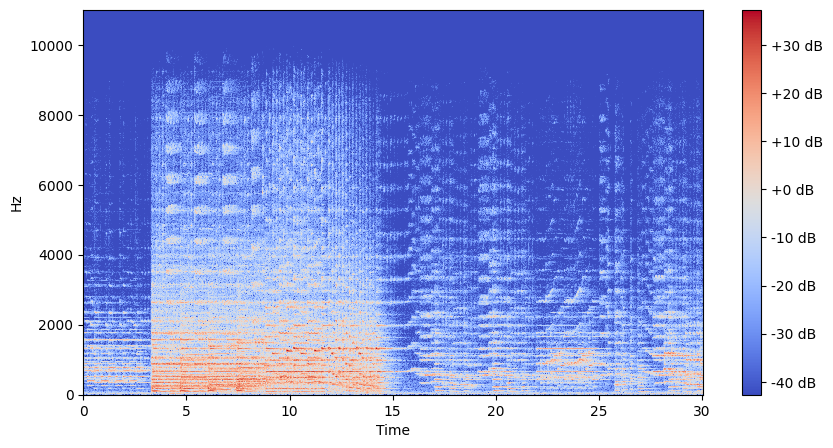

In [87]:
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]

print(wav_names[int(random_index)])

plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=22000, hop_length=512)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

Audio(data=clip, rate=sfreq)


#### De Spectrogram data gebruiken als Features 
Nu we een dieper inzicht hebben in spectrogrammen als tweedimensionale weergaves van geluid, laten we eens kijken naar de praktische toepassing ervan voor het clusteren van audioclips.

In het begrijpen van de kenmerken van verschillende audiogenres maken we gebruik van spectrogrammen. Deze visualisaties gevven ons inzicht in de frequentie-inhoud van audio over tijd, waardoor we substiele patronen van verschillende genres kunnen onderscheiden

Echter als we deze informatie verder willen gebruiken voor UnSupervised learning willen we gebruik makevan aanvullende features. Hier hebben we gekozen voor de bandwidths en de centroids van elke spectrogram

Spectral Centroid: Is het "Zwaartepunt" van de frequentie-inhoud. Het geeft het gemiddelde van de frequentiecomponenten van een audioclip. Dit wordt berekend als het gewogen gemiddelde van de frequenties waarbij hogere frequenties dus zwaarder worden gewogen. Een hoge of lage centroid waarde kan dus correleren met een bepaalde genre die wij moeten clusteren. Bijvoorbeeld klassieke muziek kan een lagere centroid hebben dan rockmuziek

Spectral Bandwidth: Dit geeft de breedte van het frequentie spectrum weer en meet hoe verspreid de frequentiecomponenten zijn. De bandwidth kan verschillen in de textuur van geluid vastleggen. Genres met een complex arrangement kunnen een bredere bandbreedte hebben dan genres met een meer eenvoudig arrangement. (Arrangement houd beknopt in: de manier waarop een muziekstuk is georganiseerd aan de hand van bijvoorbeeld de harmonië van een nummer of het ritme van een nummer)

In de onderstaande code wordt de functie "calculate_spectral_features" gedefinieerd en aangeroepen met twee verschillende lijsten met spectogrammen. De functie berekent de bandwith en de centroid voor alle spectogrammen in de lijsten.

In [8]:
def calculate_spectral_features(spectrograms):
    """
    Calculate the centroid and bandwidth for each spectrogram in a list.

    Parameters:
    - spectrograms: A list of spectrograms.

    Returns:
    - bandwidths: A list of bandwidths corresponding to each spectrogram
    - centroids: A list of centroids corresponding to each spectrogram
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        bw = lr.feature.spectral_bandwidth(S=spectrogram)

        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        cent = lr.feature.spectral_centroid(S=spectrogram)

        # Append the spectral bandwidth to the list
        bandwidths.append(bw)

        # Append the spectral centroid to the list
        centroids.append(cent)

    return bandwidths, centroids
    
# Use function
bandwidths, centroids = calculate_spectral_features(spectrograms)
bandwidths_l, centroids_l = calculate_spectral_features(spectrograms_l)

### Visualiseren Spectrogram met de Bandwidths en Centroids
Hieronder selecteren we een willekeurig spectogram en halen we daar informatie van op. Dat spectogram, de spectrale centroid en de bandbreedte worden vervolgens gevisualiseerd en uitiendelijk wordt de audioclip afgespeeld met de juiste audiofrequentie. wordt gevisualiseerd

In deze code wordt eerst een willekeurig spectrogram geselecteerd uit de lijst spectrograms_db, en vervolgens worden de bijbehorende tijdindexwaarden, spectrale bandbreedte (bw), centroid (cent), audioclip (clip), en samplefrequentie (sfreq) opgehaald. Daarna wordt het spectrogram samen met de spectrale centroid en bandbreedte gevisualiseerd met behulp van plt (matplotlib), en tot slot wordt de bijbehorende audioclip afgespeeld met de juiste samplefrequentie.

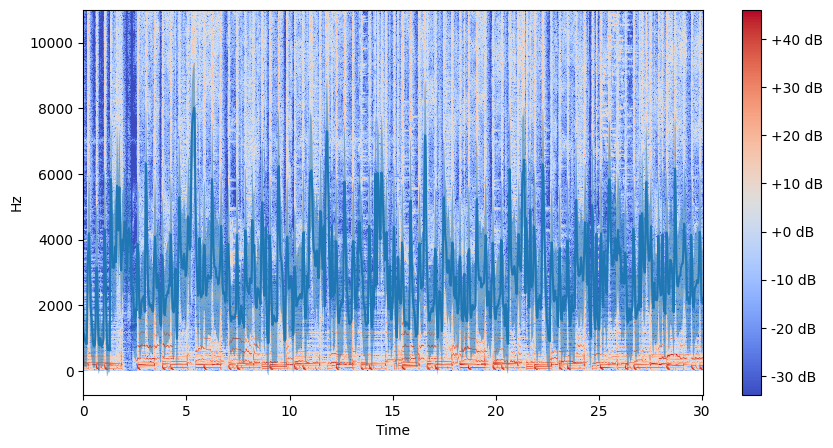

In [9]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]

# Get time index values
times_spec = lr.frames_to_time(range(spectrogram.shape[1]), sr=22000, hop_length=512)

bw = bandwidths[random_index[0]][0]
cent = centroids[random_index[0]][0]

clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=22000, hop_length=512)
plt.plot(times_spec, cent)
plt.fill_between(times_spec, cent - bw / 2, cent + bw / 2, alpha=.5)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)


#### Toevoeging:
Wat we nu kunnen zien in de visualisatie is dat de bandbreedte is weergeven in de visualisatie als schaduwgebied rond de Spectral Centroid lijn. Beide toegevoegde features kun je nu visueel zien in de visualisatie. Dit maakt het makkelijker om visuele informatie te koppelen aan de Audio die je hoort in de Clips en kan helpen bij het begrip van de audiopatronen, sinds het per audio clip nu nieuwe informatie geeft om patronen vast te stellen

In [10]:
#Hier maken we van de Centroids en Bandwidths gemiddeldes zodat je het beter kan gebruiken in clustering
mean_bw = np.squeeze(np.mean(bandwidths, axis=-1), axis=-1)
mean_cent = np.squeeze(np.mean(centroids, axis=-1), axis=-1)
mean_bw_l = np.squeeze(np.mean(bandwidths_l, axis=-1), axis=-1)
mean_cent_l = np.squeeze(np.mean(centroids_l, axis=-1), axis=-1)

In [11]:
len(spectrograms_l)

649

In [12]:
features = pd.DataFrame(columns=['mean_bandwidth','mean_centroids'])
features_l = pd.DataFrame(columns=['name','genre','mean_bandwidth','mean_centroids'])

features['mean_bandwidth'] = mean_bw
features['mean_centroids'] = mean_cent

features_l['name'] = labels['filename']
features_l['genre'] = labels['genre']
features_l['mean_bandwidth'] = mean_bw_l
features_l['mean_centroids'] = mean_cent_l

features_ltemp = features_l[features_l['genre'].isin(['pop', 'classical', 'metal'])]

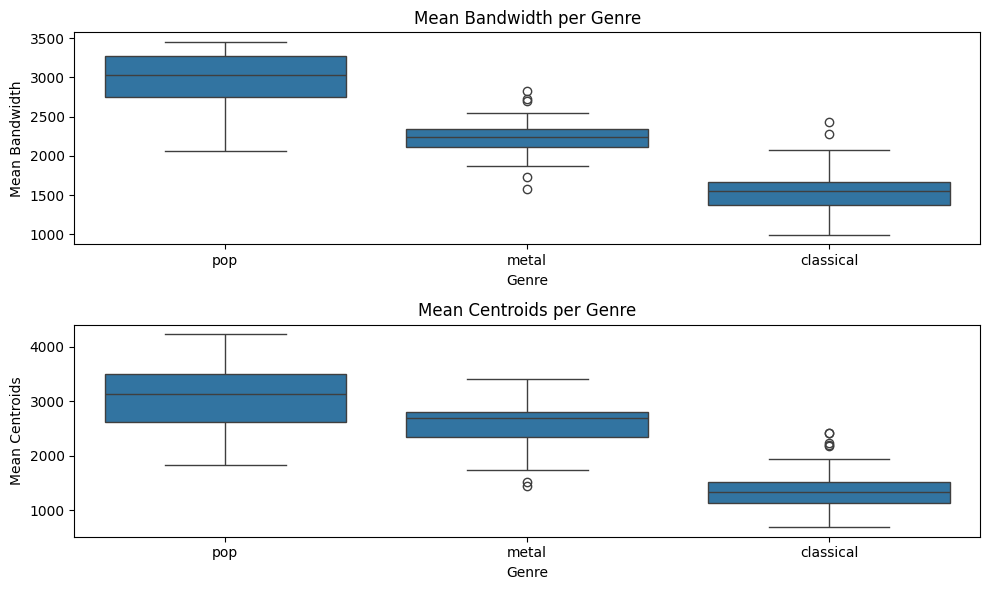

In [13]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sns.boxplot(x='genre', y='mean_bandwidth', data=features_ltemp)
plt.title('Mean Bandwidth per Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Bandwidth')

plt.subplot(2, 1, 2)
sns.boxplot(x='genre', y='mean_centroids', data=features_ltemp)
plt.title('Mean Centroids per Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Centroids')

plt.tight_layout()
plt.show()

In [14]:
features

mean_bandwidth  mean_centroids
0       2070.908729     2254.451748
1       2286.246872     2908.260266
2       1865.851544     1953.012399
3       2073.302486     2384.812610
4        899.979779      790.478225
..              ...             ...
100     1588.161024     1525.601267
101     3295.553789     3671.260488
102     3361.504206     3940.349921
103     1404.132189      983.761841
104     1371.336609     1253.132223

[105 rows x 2 columns]

### MFCC (Mel-Frequency Cepstral Coefficients)
Mel-frequency:
De perceptie van geluidsfrequenties door het mensenlijk oor is niet uniform. Mel-Frequency scaling is een vorm van scaling die specifiek is ontworpen om de perceptie van geluid beter te weergeven dan de standaard schaal die we vaak gebruiken "Hertz (HZ)". Deze schaal is van belang bij het begrijpen hoe mensen verschillende frequenties ervaren (Music Information Retrieval (z.d.))

Cepstral Coefficients: 
Ceptrale analyse wordt gebruikt om informatie te krijgen over periodische en resonante eigenschap. Dit zijn de aanwezigheid van herhaling en regelmaat (Periodisch) en de aanwezigheid van een sterke response op trillingen of vibraties door frequenties. (Math Works. 2023.).

MFCC's bieden een zeer goede representatie van audiogegevens door de audio perceptie van mensenlijk gehoor duidelijk te kunnen weergeven. De MFFC's bieden een compacte weergave van geluid waardoor het makkelijk te verwerken is zowel als er veel als weinig gegevens voor handen zijn. De MFFC's geven relevante kenmerken zoals toonhoogte, ritme en timbre weer die cruciaal zijn voor het identificeren van muziekgenres. MFFC's zijn erg effectief in machine-learning modellen voor vooral clustering en classificatie van muziekgenres


In [15]:
def generate_mfccs(filenames, base_dir):
    result = []

    for filename in filenames:
        audiofile = os.path.join(base_dir, filename)
        data, sfreq = lr.load(audiofile, sr=None)
        mfccs = lr.feature.mfcc(y=data, sr=sfreq)

        mfccs_dict = {}
        for num in range(len(mfccs)):
            mfcc_mean = np.mean(mfccs[num, :])
            mfccs_dict[f'mfcc{num + 1}_mean'] = mfcc_mean

        result.append(mfccs_dict)

    new_df = pd.concat([pd.DataFrame(item, index=[0]) for item in result], keys=filenames)
    
    new_df['mean_of_columns'] = new_df.mean(axis=1)

    return new_df

result_df = generate_mfccs(wav_names, base_dir)
result_df_l = generate_mfccs(wav_names_l, base_dir_l)

display(result_df)

mfcc1_mean  mfcc2_mean  mfcc3_mean  mfcc4_mean  mfcc5_mean  \
m00003.wav 0  -82.511116   97.341721  -34.367931   71.408501   -3.292029   
m00012.wav 0   -1.913298   72.686157  -32.791992   63.605476  -18.556351   
m00013.wav 0 -287.603699  101.758171  -35.345406   41.280159  -12.727131   
m00043.wav 0 -120.147491   91.317215  -38.845890   75.008400   -3.813260   
m00044.wav 0 -437.604401  170.931534    7.419581   -3.083473    0.789382   
...                  ...         ...         ...         ...         ...   
m00971.wav 0 -246.158646  149.428665  -41.988865   11.606256  -10.289648   
m00973.wav 0   -8.573005   54.295788   20.964115   13.100406    9.715855   
m00988.wav 0  -56.153061   36.448502   11.979400   -6.415675    3.782166   
m00991.wav 0 -406.846680  163.081345   -2.372812   32.416626    7.946261   
m00995.wav 0 -223.187332  163.253967  -34.412884   24.186995  -10.303666   

              mfcc6_mean  mfcc7_mean  mfcc8_mean  mfcc9_mean  mfcc10_mean  \
m00003.wav 0   17.375372   -9.026282   16.017792  -19.010939    12.084585   
m00012.wav 0   25.870161  -13.859100   18.078884  -11.946615    19.672184   
m00013.wav 0   17.276148  -13.967989   16.304947   -5.592962    13.654110   
m00043.wav 0   22.665588   -8.119440   23.654900  -14.630774    13.370975   
m00044.wav 0  -11.128749  -12.522781   -6.907836   -5.858702    -8.461237   
...                  ...         ...         ...         ...          ...   
m00971.wav 0   -4.019358   -7.136855  -10.135562   -9.420322    -7.171843   
m00973.wav 0    6.022176   10.730787    6.106817    0.696941     5.003989   
m00988.wav 0    5.288355    3.395965    4.261923    7.989973     5.857593   
m00991.wav 0    9.632712   -5.456720    9.490358   -3.060804    10.187205   
m00995.wav 0    3.222132  -12.889323    0.803704  -14.281190     1.678858   

              ...  mfcc12_mean  mfcc13_mean  mfcc14_mean  mfcc15_mean  \
m00003.wav 0  ...    13.953283   -14.459843     7.957753    -7.127908   
m00012.wav 0  ...    18.755697   -11.187991     7.958545   -10.288300   
m00013.wav 0  ...    -0.053095   -13.757536     6.476344     6.705066   
m00043.wav 0  ...    13.706296    -9.315235     3.592223   -11.855697   
m00044.wav 0  ...    -8.339388    -7.378575    -6.732569    -6.086592   
...           ...          ...          ...          ...          ...   
m00971.wav 0  ...    -5.640657    -2.586296    -4.517968    -6.158670   
m00973.wav 0  ...     0.874806    -1.936897    -2.783131    -2.666644   
m00988.wav 0  ...     4.853725     0.495775     2.506890     0.274046   
m00991.wav 0  ...    -5.404833    -8.054707    -2.080017     0.383961   
m00995.wav 0  ...     0.231517    -4.558466     0.102354    -2.858845   

              mfcc16_mean  mfcc17_mean  mfcc18_mean  mfcc19_mean  mfcc20_mean  \
m00003.wav 0     5.176864    -7.204415     0.672431    -4.835922    -2.104596   
m00012.wav 0     5.317202    -9.030465     4.323158    -5.639724     8.738863   
m00013.wav 0     6.980088     7.022009     8.379350    -5.610406     1.377615   
m00043.wav 0     1.029913   -10.711127    -3.246828    -3.465947    -4.581296   
m00044.wav 0    -7.061233    -6.655329    -4.290077    -4.392879    -4.906606   
...                   ...          ...          ...          ...          ...   
m00971.wav 0    -4.969988    -3.351599    -3.347440    -0.674225     0.220390   
m00973.wav 0    -3.311479     1.708261    -0.152766     4.846820     2.906235   
m00988.wav 0    -2.596172    -1.426308    -1.872723    -5.402517    -4.322453   
m00991.wav 0     3.408478     3.502833     7.379328     6.431856     0.185726   
m00995.wav 0     1.356862    -0.333458    -1.061215    -1.097797    -8.051071   

              mean_of_columns  
m00003.wav 0         2.423996  
m00012.wav 0         5.791912  
m00013.wav 0        -7.811633  
m00043.wav 0         0.310461  
m00044.wav 0       -18.537571  
...                       ...  
m00971.wav 0       -10.473551  
m00973.wav 0         5.705091  
m00988.wav 0         0.526684  
m00991

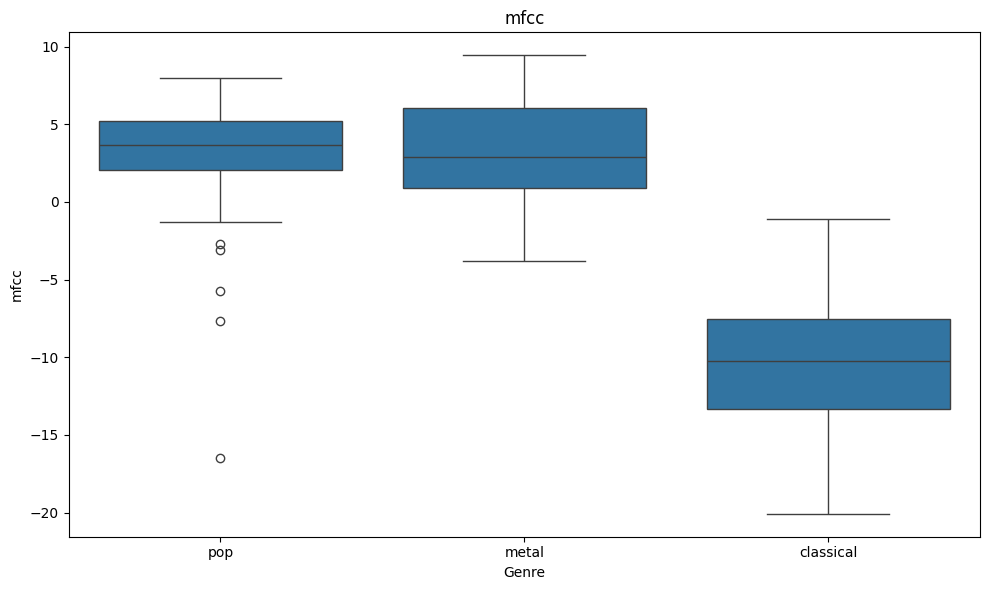

In [16]:
features_l['mfcc'] = list(result_df_l['mean_of_columns']) 
features_ltemp = features_l[features_l['genre'].isin(['pop', 'classical', 'metal'])]

plt.figure(figsize=(10, 6))

sns.boxplot(x='genre', y='mfcc', data=features_ltemp)
plt.title('mfcc')
plt.xlabel('Genre')
plt.ylabel('mfcc')

plt.tight_layout()
plt.show()

# Zero Crossing Rate

De zero crossing rate is een feature die kan worden gebruikt om ritme en timbre te duiden. Timbre betekent het unieke karakter van een instrument of stem, dat mede wordt gevormd door de onder- en overtonen en de nuldoorgangssnelheid beïnvloeden. De zero crossing rate kan dus iets zeggen over de gebruikte instrumenten in de muziek. Met name de classificering van instrumenten die onder de noemer "percussie" vallen, dus slaginstrumenten zoals een drumstel of een pauk, kunnen door de nuldoorgangssnelheid worden onderscheiden.  
De zero crossing rate meet hoe snel de overgang in het gel is van positief naar negatief en andersom is(Wikipedia). In de negatieve delen, waarbij het geluidssignaal op de x-as zit of daaronder zit, is er sprake van stilte. Als het geluidssignaal boven de x-as zit, is er sprake van geluid. Het patroon van de snelheid waarmee positief enerzijds en negatief en nul anderzijds elkaar afwisselen verschilt per instrument en stem en is daarom in elk geval op het eerste gezicht een nuttige feature (MrAudioSoundImages). 

In [88]:
def calculate_zero_crossing_rate(audio_clips, hop_length=512):
    zero_crossing_rates = []

    for clip in audio_clips:
        zero_crossings = lr.zero_crossings(clip, pad=False)
        rate = np.sum(zero_crossings) / len(clip)
        zero_crossing_rates.append(rate)

    return zero_crossing_rates

zero_crossing_rates = calculate_zero_crossing_rate(audio_data)
zero_crossing_rates_l = calculate_zero_crossing_rate(audio_data_l)

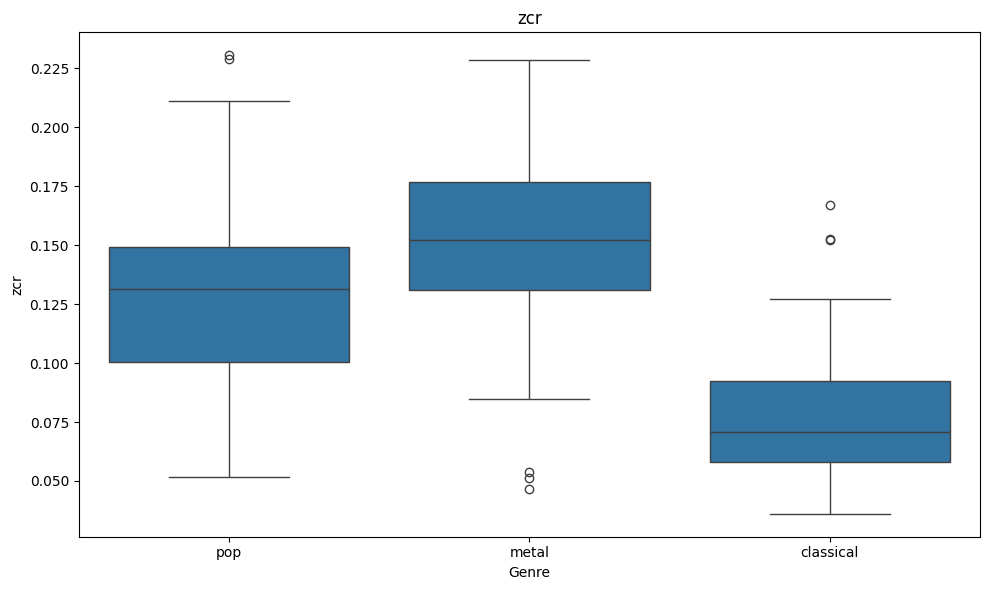

In [18]:
features_l['zcr'] = zero_crossing_rates_l
features_ltemp = features_l[features_l['genre'].isin(['pop', 'classical', 'metal'])]

plt.figure(figsize=(10, 6))

sns.boxplot(x='genre', y='zcr', data=features_ltemp)
plt.title('zcr')
plt.xlabel('Genre')
plt.ylabel('zcr')

plt.tight_layout()
plt.show()

# Harmonic numbers


In de code hieronder wordt een lijst met boventonen (overtones) teruggegeven van de aan de functie gegeven audiofragmenten. 

### Wat zijn boventonen?
Overtonen zijn tonen die tegelijk klinken met een grondtoon bij het bespelen van een instrument, zoals een gitaar. De harmonische boventonen (harmonic overtones) zijn tonen die gehele tonen, of een veelvoud van tonen boven de grondtoon liggen. De grondtoon is de basis van de muziek. Door onze eigen ervaring in de muziek weten we dat de melodie, de harmonie en de akkoorden zijn gebaseerd op de grondtoon van de muziek. Om te kijken of boventonen van significante invloed zijn op het voorspellen van genres filteren we hieronder een lijst met boventonen van de audiofragmenten. 


### Overtones verkrijgen
Om dat voor elkaar te krijgen worden allereerst de harmonie en de percussie van elkaar gescheiden. En dan komt er een getal uit dat de mate van harmonie in de overgebleven audio aangeeft, oftewel de muziek van niet-percussie-instrumenten, zang en andere geluidseffecten. Dat gebeurt met behulp van librosa.effects.harmonics. (LibROSA. (z.d.). librosa.effects.harmonic.)

$audioclip - percussie = harmonie $

De code maakt gebruik van de librosa-bibliotheek om de korte-termijn Fourier-transformatie (STFT) van de audioclips te berekenen.
Het ritme en de harmonie worden gescheiden door middel van de hpss-functie (LibROSA. (z.d.). librosa.effects.hpss.) Vervolgens wordt de percussieve component van de clip verwijderd. Het uiteindelijke harmonische getal wordt berekend op basis van het overgebleven harmonische stuk. De  lijst harmonic_numbers bevat deze harmonische getallen voor alle muziekclips.
Het maakt niet uit of een getal positief of negatief is, omdat wij de grootheid willen zien van een getal. Dus we hebben alle getallen omgezet naar positieve waarden (de absolute waarden). Hoe kleiner een getal van harmonic_number_abs is, des te groter het percussie-aandeel in de muziek. En hoe groter een dergelijk harmonisch getal is, des te kleiner de hoeveelheid slaginstrumenten in de muziek is. 



In [19]:
import librosa as lr
import numpy as np

def calculate_harmonic_number(audio_clips, n_fft=1024, hop_length=512, win_length=None):
    harmonic_numbers = []

    for clip in audio_clips:
        try:
            if len(clip) < n_fft:
                clip = np.pad(clip, (0, n_fft - len(clip)))
                
            stft = lr.stft(clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
            spec = np.abs(stft)
            harmonic, _ = lr.effects.hpss(clip)
            
            result = lr.effects.harmonic(harmonic)
            harmonic_number = result[1]  # Extract the second value (harmonic number)

            harmonic_numbers.append(harmonic_number)
        except Exception as e:
            print(f"Error processing clip: {e}")

    return harmonic_numbers

harmonic_numbers = calculate_harmonic_number(audio_data, n_fft=1024, hop_length=512, win_length=None)
harmonic_numbers_l = calculate_harmonic_number(audio_data_l, n_fft=1024, hop_length=512, win_length=None)

harmonic_numbers_abs = np.abs(harmonic_numbers)
harmonic_numbers_abs_l = np.abs(harmonic_numbers_l)

print(harmonic_numbers_abs)


[8.73922035e-02 6.07883856e-02 5.41154388e-03 5.73495626e-02
 7.23798480e-03 6.29569665e-02 1.59169026e-02 5.13435341e-02
 2.29409989e-03 1.01646282e-01 5.83726587e-03 1.83557361e-01
 1.85728259e-02 2.88444646e-02 2.30243127e-03 1.30309183e-02
 1.24753833e-01 9.67894972e-04 1.40102580e-01 1.94811299e-02
 5.99882752e-02 1.73570037e-01 6.48907200e-02 2.78817471e-02
 2.86495686e-02 1.01190500e-01 2.74995118e-02 6.28851205e-02
 2.37964429e-02 1.61539659e-01 2.45807576e-04 1.05060846e-01
 8.41373391e-03 5.95018687e-03 1.79956580e-04 1.84240825e-02
 2.30104983e-01 3.56738940e-02 2.61324290e-02 8.14730898e-02
 2.26660639e-01 1.31007843e-02 3.80552039e-02 1.52035160e-02
 5.02198702e-03 4.19893898e-02 4.85558761e-03 1.50550166e-02
 6.67622639e-03 1.39198452e-03 9.02763158e-02 5.82526810e-02
 1.17942311e-01 1.51093796e-01 3.50514916e-03 4.58950587e-02
 2.18455726e-03 3.47551927e-02 1.74710657e-02 2.25425735e-01
 2.01318171e-02 1.87440831e-02 3.55552329e-04 1.77448895e-02
 3.08205024e-03 1.214214

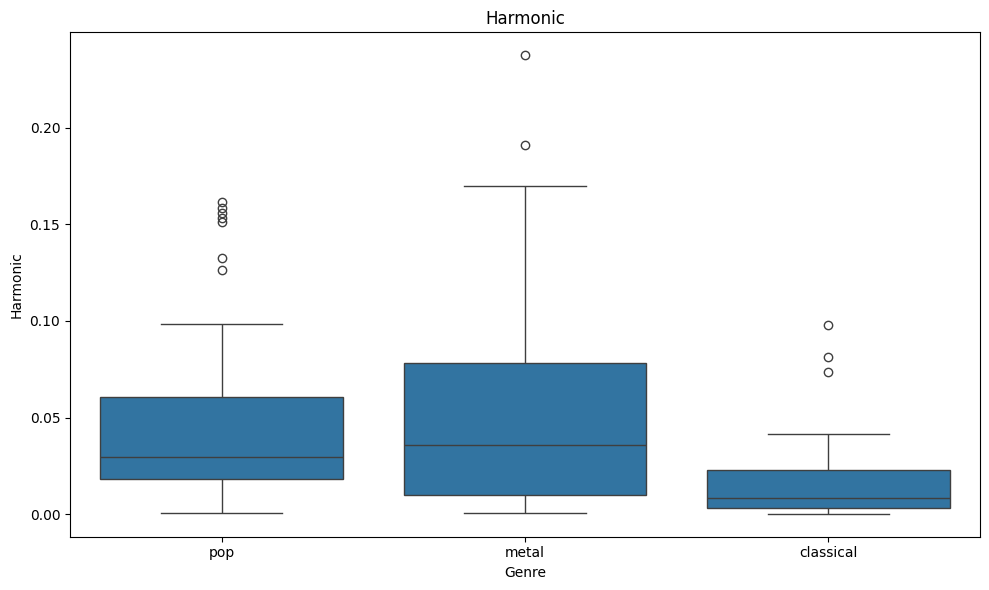

In [20]:
features_l['Harmonic'] = harmonic_numbers_abs_l
features_ltemp = features_l[features_l['genre'].isin(['pop', 'classical', 'metal'])]

plt.figure(figsize=(10, 6))

sns.boxplot(x='genre', y='Harmonic', data=features_ltemp)
plt.title('Harmonic')
plt.xlabel('Genre')
plt.ylabel('Harmonic')

plt.tight_layout()
plt.show()

# Zero Crossing variability

Zero crossing rate variability (OpenAI 1) is een feature waarbij de variatie in de zero crossing rate wordt onderzocht van de audioclips. De mate van verandering, dus de variabiliteit (NumPy) wordt hier berekend over de zero crossing rate. Als de zero crossing rate variability hoog uitkomt, dan is er veel variatie in de muziek te vinden, zoals grote toonverschillen of volumeverschillen.

ZCR-variabiliteit 1: 0.10583428131282743
ZCR-variabiliteit 2: 0.14655632618553427
ZCR-variabiliteit 3: 0.10831348047367097
ZCR-variabiliteit 4: 0.11032859331017197
ZCR-variabiliteit 5: 0.04944632104935698
ZCR-variabiliteit 6: 0.06186700273834233
ZCR-variabiliteit 7: 0.12174398046538687
ZCR-variabiliteit 8: 0.14018215576842977
ZCR-variabiliteit 9: 0.05597806211517948
ZCR-variabiliteit 10: 0.08027219311340894
ZCR-variabiliteit 11: 0.12097622881184054
ZCR-variabiliteit 12: 0.11131891555473283
ZCR-variabiliteit 13: 0.030581046600953305
ZCR-variabiliteit 14: 0.15104006084341856
ZCR-variabiliteit 15: 0.131225729496569
ZCR-variabiliteit 16: 0.09464127885443249
ZCR-variabiliteit 17: 0.0964165820254364
ZCR-variabiliteit 18: 0.0396332092903677
ZCR-variabiliteit 19: 0.09014750944765243
ZCR-variabiliteit 20: 0.13625925106422845
ZCR-variabiliteit 21: 0.1546651526450171
ZCR-variabiliteit 22: 0.14969924282577726
ZCR-variabiliteit 23: 0.08470213194205206
ZCR-variabiliteit 24: 0.08056229254271624
ZCR-v

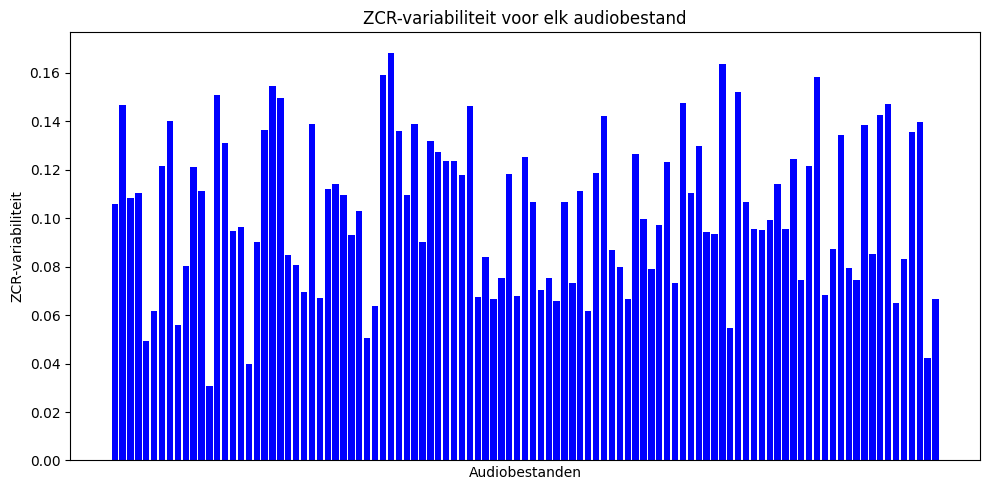

In [21]:
def calculate_zcr_variability(audio_clips, hop_length=512):
    zcr_variabilities = []

    for clip in audio_clips:
        zero_crossings = lr.zero_crossings(clip, pad=False)
        zcr_variability = np.var(zero_crossings)
        zcr_variabilities.append(zcr_variability)

    return zcr_variabilities

zcr_variabilities = calculate_zcr_variability(audio_data)
zcr_variabilities_l = calculate_zcr_variability(audio_data_l)

for i, zcr_variability in enumerate(zcr_variabilities):
    print(f"ZCR-variabiliteit {i + 1}: {zcr_variability}")
    
import matplotlib.pyplot as plt

indices = range(1, len(zcr_variabilities) + 1)

plt.figure(figsize=(10, 5))
plt.bar(indices, zcr_variabilities, color='blue')
plt.xlabel('Audiobestanden')
plt.ylabel('ZCR-variabiliteit')
plt.title('ZCR-variabiliteit voor elk audiobestand')
plt.xticks([])  # Hiermee worden de x-ticklabels uitgeschakeld
plt.tight_layout()
plt.show()



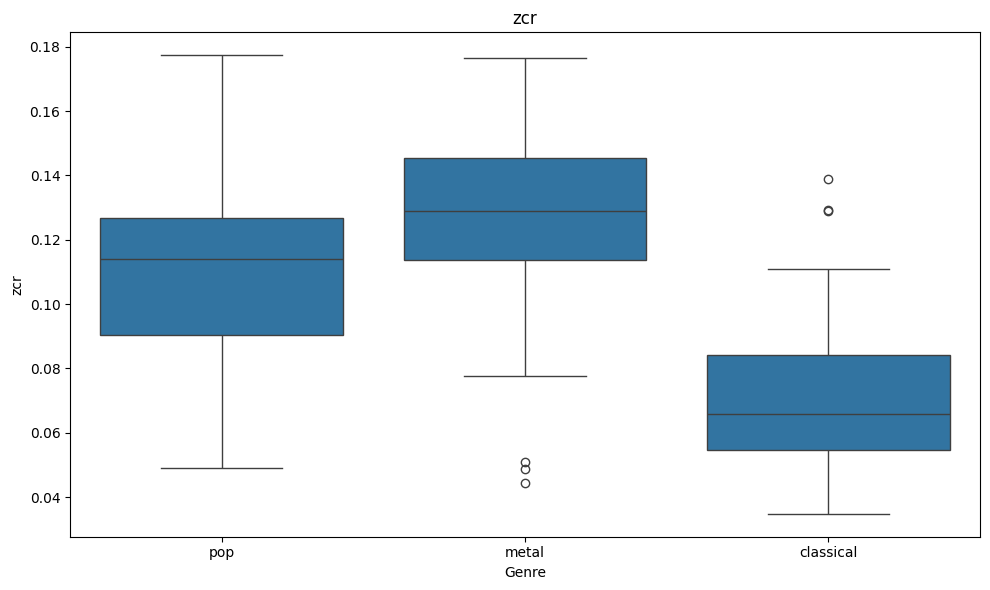

In [22]:
features_l['zcr'] = zcr_variabilities_l
features_ltemp = features_l[features_l['genre'].isin(['pop', 'classical', 'metal'])]

plt.figure(figsize=(10, 6))

sns.boxplot(x='genre', y='zcr', data=features_ltemp)
plt.title('zcr')
plt.xlabel('Genre')
plt.ylabel('zcr')

plt.tight_layout()
plt.show()

# Tempo

Het tempo van muziek wordt vaak uitgedrukt in slagen per minuut; beats per minute (BPM). Hieronder wordt met onset_strength eerst de beat geidentificeerd in het muziekstuk (librosa development team). Daarna vindt er een schatting van het tempo plaats.

Tempo 1: 132.51201923076923 BPM
Tempo 2: 139.6748310810811 BPM
Tempo 3: 97.50884433962264 BPM
Tempo 4: 139.6748310810811 BPM
Tempo 5: 117.45383522727273 BPM
Tempo 6: 107.666015625 BPM
Tempo 7: 114.84375 BPM
Tempo 8: 123.046875 BPM
Tempo 9: 132.51201923076923 BPM
Tempo 10: 143.5546875 BPM
Tempo 11: 117.45383522727273 BPM
Tempo 12: 109.95678191489361 BPM
Tempo 13: 132.51201923076923 BPM
Tempo 14: 132.51201923076923 BPM
Tempo 15: 129.19921875 BPM
Tempo 16: 151.99908088235293 BPM
Tempo 17: 143.5546875 BPM
Tempo 18: 135.99917763157896 BPM
Tempo 19: 123.046875 BPM
Tempo 20: 139.6748310810811 BPM
Tempo 21: 112.34714673913044 BPM
Tempo 22: 114.84375 BPM
Tempo 23: 117.45383522727273 BPM
Tempo 24: 120.18531976744185 BPM
Tempo 25: 143.5546875 BPM
Tempo 26: 109.95678191489361 BPM
Tempo 27: 161.4990234375 BPM
Tempo 28: 112.34714673913044 BPM
Tempo 29: 126.04801829268293 BPM
Tempo 30: 135.99917763157896 BPM
Tempo 31: 151.99908088235293 BPM
Tempo 32: 117.45383522727273 BPM
Tempo 33: 120.1853197674418

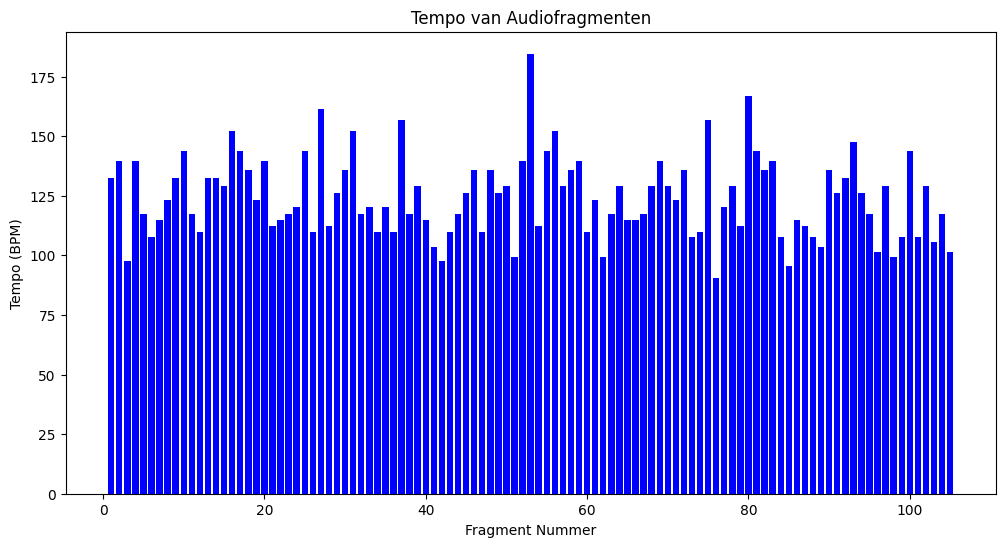

In [23]:
def estimate_tempo(audio_clips, sr=44100):
    tempos = []

    for clip in audio_clips:
        onset_env = lr.onset.onset_strength(y=clip, sr=sr)
        tempo, _ = lr.beat.beat_track(onset_envelope=onset_env, sr=sr)
        tempos.append(tempo)

    return tempos

tempos = estimate_tempo(audio_data)
tempos_l = estimate_tempo(audio_data_l)


#NKOK: voor mezelf een print, mag weg in het uiteindelijke werk.
for i, tempo in enumerate(tempos):
    print(f"Tempo {i + 1}: {tempo} BPM")
    
import matplotlib.pyplot as plt


fragment_numbers = range(1, len(tempos) + 1)

plt.figure(figsize=(12, 6))
plt.bar(fragment_numbers, tempos, color='blue')
plt.xlabel('Fragment Nummer')
plt.ylabel('Tempo (BPM)')
plt.title('Tempo van Audiofragmenten')
plt.show()


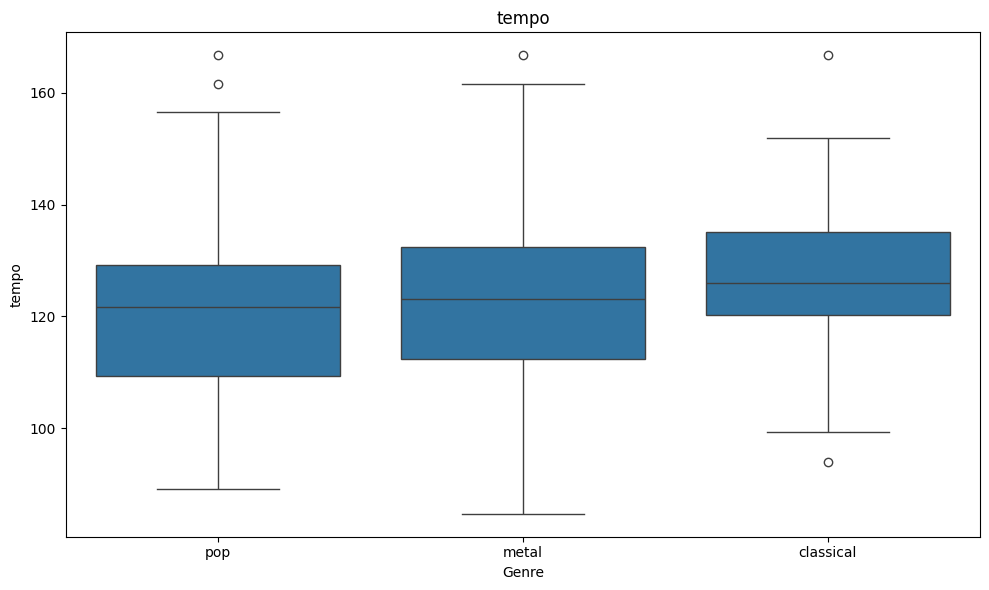

In [24]:
features_l['tempo'] = tempos_l
features_ltemp = features_l[features_l['genre'].isin(['pop', 'classical', 'metal'])]

plt.figure(figsize=(10, 6))

sns.boxplot(x='genre', y='tempo', data=features_ltemp)
plt.title('tempo')
plt.xlabel('Genre')
plt.ylabel('tempo')

plt.tight_layout()
plt.show()

# lyrics

Als laatste feature hebben we ervoor gekozen om iets met songteksten te doen. Hiervoor hebben we gebruikgemaakt van Whisper, spraakherkenningssoftware ontwikkeld door OpenAI. We kozen voor Whisper omdat we er al ervaring mee hadden en het model behoorlijk robuust is.



https://openai.com/research/whisper

In [25]:
def find_repeated_pattern(s):
    s = s.lower()
    pattern = False
    max_length = len(s) // 2

    for i in range(3, max_length + 1):
        substring = s[:i]

        repeat_count = s.count(substring)
        if repeat_count > 10:
            pattern = True
            
    return pattern

wav_names = [filename for filename in os.listdir(base_dir) if filename.endswith(".wav")]

model = whisper.load_model("base")

name = []
language = []
text = []
output = []

for index, wav_name in enumerate(wav_names):
    route = os.path.join(base_dir, wav_name)
    print("Current route:", route)

    # Rest of your code remains unchanged
    spectrogram = spectrograms_db[index][0]
    clip = audio_data[index]
    sfreq = sample_freqs[index]

    result = model.transcribe(route)

    name.append(wav_name)
    language.append(result['language'])
    text.append(result['text'])

    if result['language'] == 'la':
        output.append('prob_classical')
    elif result['language'] == 'ko':
        output.append('prob_pop')
    elif find_repeated_pattern(result['text']):
        output.append('prob_metal')
    else:
        output.append('lyrical')
 
    print(route)
    print(result['language'])
    print(result['text'])
    print('---------------------------')

base_dir is ingesteld op: C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled
Current route: C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled\m00003.wav


C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\whisper\transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled\m00003.wav
en
 I'm flying on the radio Look at your sound, the TV And playing a rare tickle-body cam Soon I'm on the stand on the screen Spinning along, knocking them down Never not a fantasy That's a bad man Drizzled around, got a bad blood, lemma see
---------------------------
Current route: C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled\m00012.wav
C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled\m00012.wav
en
 The she's not responding what you're not asking You're not a clue to get where to lay We get to lay I guess I get to lay Oh, we get to lay I guess I get to lay Yeah, I guess I get to lay The way I think it's bigger gets the buzz As soon as I'm mad Let me check to a clear and free eye Five minutes of an evil game You know I ain't no game
---------------------------
Current route: C:\Users\KaasT\Documents\The overfitters\wedstrijd 3\unlabeled\m00013.wav
C:\Users\KaasT\Documents\The over

We hebben enkele resultaten kunnen behalen. Whisper herkent automatisch de taal. Omdat klassieke nummers geen songteksten hebben, herkent Whisper die 'taal' als 'la'. Daarna hebben we een feature gemaakt met de naam "l_prob_classical", die True is als de taal 'la' is en False als dat niet het geval is. We hebben ook andere benaderingen geprobeerd. Bijvoorbeeld, bij metalnummers ziet Whisper instrumentale muziek aan voor songteksten, en denkt het dat hetzelfde stukje tekst telkens wordt herhaald. Achteraf bleek dit niet consistent genoeg om er waarde uit te halen.

# features samenvoegen

In [61]:
features = pd.DataFrame(columns=['mfcc_mean','mean_bandwidth','mean_centroids','ZCR','ZCV'])
features['name'] = name
features['lyrics'] = output
features['mean_bandwidth'] = mean_bw
features['mean_centroids'] = mean_cent
features['mfcc_mean'] = list(result_df['mean_of_columns']) 
features['harmonic_number'] = harmonic_numbers_abs
features['ZCV'] = zcr_variabilities
features['ZCR']= zero_crossing_rates
features['tempo'] = tempos

features = features.set_index('name')
features = pd.get_dummies(features, columns=['lyrics'],prefix = 'l')
features.drop(['l_lyrical', 'l_prob_metal', 'l_prob_pop'], axis=1, inplace=True)
features

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00003.wav   2.423996     2070.908729     2254.451748  0.120308  0.105834   
m00012.wav   5.791912     2286.246872     2908.260266  0.178373  0.146556   
m00013.wav  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
m00043.wav   0.310461     2073.302486     2384.812610  0.126274  0.110329   
m00044.wav -18.537571      899.979779      790.478225  0.052168  0.049446   
...               ...             ...             ...       ...       ...   
m00971.wav -10.473551     1588.161024     1525.601267  0.091711  0.083300   
m00973.wav   5.705091     3295.553789     3671.260488  0.162033  0.135778   
m00988.wav   0.526684     3361.504206     3940.349921  0.167811  0.139650   
m00991.wav  -9.479113     1404.132189      983.761841  0.044275  0.042315   
m00995.wav  -6.416987     1371.336609     1253.132223  0.071732  0.066587   

            harmonic_number       tempo  l_prob_classical  
name                                                       
m00003.wav         0.087392  132.512019             False  
m00012.wav         0.060788  139.674831             False  
m00013.wav         0.005412   97.508844              True  
m00043.wav         0.057350  139.674831             False  
m00044.wav         0.007238  117.453835              True  
...                     ...         ...               ...  
m00971.wav         0.000240  107.666016              True  
m00973.wav         0.114283  129.199219             False  
m00988.wav         0.000038  105.468750             False  
m00991.wav         0.001587  117.453835              True  
m00995.wav         0.028202  101.332721              True  

[105 rows x 8 columns]

In [62]:
scaler = StandardScaler()

df = scaler.fit_transform(features)

df = pd.DataFrame(df, columns=features.columns)

display(df)




mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
0     0.561470       -0.282118       -0.118884  0.026882  0.082675   
1     1.038974        0.019216        0.616770  1.408001  1.364237   
2    -0.889737       -0.569065       -0.458058  0.104873  0.160698   
3     0.261814       -0.278768        0.027796  0.168769  0.224116   
4    -2.410460       -1.920661       -1.766122 -1.593893 -1.691908   
..         ...             ...             ...       ...       ...   
100  -1.267143       -0.957653       -0.938974 -0.653322 -0.626490   
101   1.026664        1.431593        1.475285  1.019339  1.025048   
102   0.292470        1.523881        1.778059  1.156768  1.146904   
103  -1.126152       -1.215174       -1.548642 -1.781626 -1.916342   
104  -0.692004       -1.261066       -1.245551 -1.128534 -1.152478   

     harmonic_number     tempo  l_prob_classical  
0           0.734240  0.481575         -0.707107  
1           0.249261  0.905698         -0.707107  
2          -0.760242 -1.591026          1.414214  
3           0.186572  0.905698         -0.707107  
4          -0.726946 -0.410047          1.414214  
..               ...       ...               ...  
100        -0.854525 -0.989601          1.414214  
101         1.224446  0.285418         -0.707107  
102        -0.858203 -1.119706         -0.707107  
103        -0.829954 -0.410047          1.414214  
104        -0.344776 -1.364607          1.414214  

[105 rows x 8 columns]

# clustering

We hebben nu een tabel met 8 features die we kunnen gebruiken voor ons clustering-algoritme. Uit de boxplots blijkt dat features zoals harmonic_number waarschijnlijk niet goed werken, omdat er weinig verschil is tussen pop-, metal- en klassieke nummers. Aan de andere kant lijkt het erop dat features zoals mean_bandwidth waarschijnlijk wel effectief zijn. Om te ontdekken welke kenmerken het meest doeltreffend zijn om het genre te bepalen, hebben we elke combinatie van onze variabelen in subsets opgeslagen. Op deze manier kunnen we elke subset testen.

In [63]:
import itertools

# Get the column names
columns = df.columns

# Generate all combinations of column names
all_combinations = []
for r in range(1, len(columns) + 1):
    combinations_r = itertools.combinations(columns, r)
    all_combinations.extend(combinations_r)

# Create subset DataFrames for each combination
subset_dfs = {}
for i, combination in enumerate(all_combinations):
    subset_df = df[list(combination)]
    subset_dfs[f"subset_df_{i+1}"] = subset_df


for key, subset_df in subset_dfs.items():
    subset_columns = subset_df.columns.tolist()
    print(f"Subset DataFrame '{key}' - Columns: {subset_columns}")
    #display(subset_df)
    #print("\n")

#https://chat.openai.com/share/fad44ce6-36c0-476b-a3fd-7abf096e69fe

Subset DataFrame 'subset_df_1' - Columns: ['mfcc_mean']
Subset DataFrame 'subset_df_2' - Columns: ['mean_bandwidth']
Subset DataFrame 'subset_df_3' - Columns: ['mean_centroids']
Subset DataFrame 'subset_df_4' - Columns: ['ZCR']
Subset DataFrame 'subset_df_5' - Columns: ['ZCV']
Subset DataFrame 'subset_df_6' - Columns: ['harmonic_number']
Subset DataFrame 'subset_df_7' - Columns: ['tempo']
Subset DataFrame 'subset_df_8' - Columns: ['l_prob_classical']
Subset DataFrame 'subset_df_9' - Columns: ['mfcc_mean', 'mean_bandwidth']
Subset DataFrame 'subset_df_10' - Columns: ['mfcc_mean', 'mean_centroids']
Subset DataFrame 'subset_df_11' - Columns: ['mfcc_mean', 'ZCR']
Subset DataFrame 'subset_df_12' - Columns: ['mfcc_mean', 'ZCV']
Subset DataFrame 'subset_df_13' - Columns: ['mfcc_mean', 'harmonic_number']
Subset DataFrame 'subset_df_14' - Columns: ['mfcc_mean', 'tempo']
Subset DataFrame 'subset_df_15' - Columns: ['mfcc_mean', 'l_prob_classical']
Subset DataFrame 'subset_df_16' - Columns: ['mean

de beste combinatie wat we met de hand hebben gevonden is 'subset_df_97' met de volgende variabelen: mfcc_mean, mean_bandwidth, mean_centroids, l_prob_classical

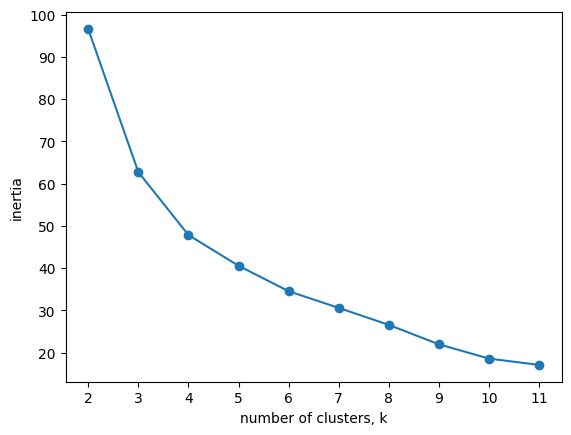

In [64]:
def inertias_plot(df):
    inertias = []
    
    ks = range(2, 12)
    for k in ks:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k,n_init=10)
        
        # Fit model to samples
        model.fit(df)
        
        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)
        
    # Plot ks vs inertias
    plt.plot(ks, inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

inertias_plot(subset_dfs['subset_df_97'])

Clustering is het toeschrijven van datapunten aan een bepaalde categorie op basis van de nabijheid bij het gemiddelde van de categorie. Hieronder volgt een simpel rekenvoorbeeld op basis van het stappenplan van het artikel "The Math Behind K-Means Clustering" (Dharmaraj. 2022, January 26).




## Simpel rekenvoorbeeld




##### Stap 1: We bepalen het aantal clusters. 
Hier kiezen we voor het gemak voor 3 clusters, omdat we uit 3 kleuren kunnen kiezen. 


##### Stap 2: We kiezen de centroids van de clusters door de gemiddelden te nemen van de datapunten van de repectievelijke kleuren. 

Stel dat daar de volgende centroids uitkomen op basis van de gemiddelden van de datapunten die respectievelijk bij een kleur horen, terwijl er voor elke categorie 10 datapunten waren:
    Centrum van cluster 1 (geel): C1(2,5)
    Centrum van cluster 2 (rood): C2(4,4)
    Centrum van cluster 3 (blauw): C3(5,1)
    
##### Stap 3: Bereken de afstand tussen het gegeven datapunt en elk clustercentrum.
Laten we het datapunt (2,6) nemen. Hier passen we de stelling van Pythagoras toe, dus Euclidische wiskunde, om te kijken naar hoe ver dit datapunt van de clustercentra afligt. 
Gegeven datapunt: $(2,6)$

Afstand tot $C1$ (geel):
$\sqrt{(2-2)^2 + (6-5)^2} = \sqrt{1} = 1 \$

Afstand tot $C2$ (rood):
$\sqrt{(2-4)^2 + (6-4)^2} = \sqrt{8} \approx 2.83 \$

Afstand tot $C3$ (blauw):
$\sqrt{(2-5)^2 + (6-1)^2} = \sqrt{26} \approx 5.1 \$

##### Stap 4: Wijs het punt toe aan het dichtstbijzijnde cluster.

Het datapunt $(2,6)$ wordt toegewezen aan cluster 1 (geel) omdat het de kortste afstand heeft tot $C1$.

##### Stap 5: Herbereken het centrum van elk cluster.

Nieuw centrum van cluster 1 (geel):
$\left( \frac{2+2}{2}, \frac{5+6}{2} \right) = (2,5.5) \$

Nieuw centrum van cluster 2 (rood):
$ \left( \frac{4}{2}, \frac{4}{2} \right) = (2,2) \


Nieuw centrum van cluster 3 (blauw):
$[ (5,1) \$ (blijft hetzelfde omdat het enige datapunt in dit cluster hetzelfde is als het initiële centrum).

##### Stap 6: Doe dit maar eens, of herhaal dit een aantal keer. 
Het aantal herhalingen hangt af van of alle datapunten op een gegeven moment in hetzelfde cluster vallen, als de centroids niet meer veranderen na toevoeging van een datapunt, of als je zelf van tevoren een aantal herhalingen hebt ingesteld. 

### Elleboogmethode
De elleboogmethode houdt in dat je kijkt naar een "elleboog" in de grafiek, dus naar het punt waar de inertie afvlakt. Deze elleboogmethode is een manier om achter de optimale hoeveelheid clusters te komen (Wikipedia. (z.d.) Elbow method.).
Het is duidelijk dat de elleboog-knik zit bij 3. Er zijn dus 3 genres in onze dataset. Daarom hebben we 3 clusters gekozen.

In [91]:
def Clustering(df, number):
    modelkm = KMeans(n_clusters = number, n_init=10, random_state=42)
    modelkm.fit(df)
    

    return modelkm.labels_
features['Cluster_Number'] = Clustering(subset_dfs['subset_df_97'], 3)
features_voor_vergelijking = features
features

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00003.wav   2.423996     2070.908729     2254.451748  0.120308  0.105834   
m00012.wav   5.791912     2286.246872     2908.260266  0.178373  0.146556   
m00013.wav  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
m00043.wav   0.310461     2073.302486     2384.812610  0.126274  0.110329   
m00044.wav -18.537571      899.979779      790.478225  0.052168  0.049446   
...               ...             ...             ...       ...       ...   
m00971.wav -10.473551     1588.161024     1525.601267  0.091711  0.083300   
m00973.wav   5.705091     3295.553789     3671.260488  0.162033  0.135778   
m00988.wav   0.526684     3361.504206     3940.349921  0.167811  0.139650   
m00991.wav  -9.479113     1404.132189      983.761841  0.044275  0.042315   
m00995.wav  -6.416987     1371.336609     1253.132223  0.071732  0.066587   

            harmonic_number       tempo  l_prob_classical  Cluster_Number  
name                                                                       
m00003.wav         0.087392  132.512019             False               1  
m00012.wav         0.060788  139.674831             False               1  
m00013.wav         0.005412   97.508844              True               0  
m00043.wav         0.057350  139.674831             False               1  
m00044.wav         0.007238  117.453835              True               0  
...                     ...         ...               ...             ...  
m00971.wav         0.000240  107.666016              True               0  
m00973.wav         0.114283  129.199219             False               2  
m00988.wav         0.000038  105.468750             False               2  
m00991.wav         0.001587  117.453835              True               0  
m00995.wav         0.028202  101.332721              True               0  

[105 rows x 9 columns]

Wij hebben een functie gemaakt om het automatish te kunnen clusteren. Je vult alleen de subset en het aantal clusters in.
[moet uitgebreider]

Wij gaan nu kijken welke cluster welke genre hoort.

In [77]:
df1 = features[features['Cluster_Number'] == 0]
df2 = features[features['Cluster_Number'] == 1]
df3 = features[features['Cluster_Number'] == 2]
display(df1, df2, df3)

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00013.wav  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
m00044.wav -18.537571      899.979779      790.478225  0.052168  0.049446   
m00069.wav -16.663797     1502.891671     1281.814379  0.059521  0.055978   
m00074.wav  -0.051628     1554.818602     1465.595383  0.088020  0.080272   
m00127.wav -14.452309     1617.435431      973.554796  0.031578  0.030581   
m00156.wav -21.571781     1030.602431      715.477296  0.041342  0.039633   
m00266.wav  -6.699692     1558.487692     1431.542306  0.075320  0.069647   
m00292.wav  -8.498735     1572.522989     1360.000106  0.072245  0.067026   
m00323.wav   0.162670     1607.525214     1712.466256  0.116419  0.102865   
m00324.wav  -9.799267     1171.747322      901.785688  0.053507  0.050644   
m00331.wav  -7.801135     1367.107711     1211.215119  0.068540  0.063842   
m00414.wav -12.017561     1525.255383     1396.692427  0.072723  0.067434   
m00434.wav  -9.153802     1578.592597     1558.898532  0.092330  0.083805   
m00463.wav -15.381470     1412.178906     1181.512556  0.071811  0.066654   
m00468.wav  -9.759991     1480.584417     1137.952953  0.081971  0.075252   
m00495.wav  -6.872644     1516.129631     1358.926260  0.073235  0.067872   
m00537.wav  -7.622735     1574.088221     1396.786119  0.075959  0.070189   
m00538.wav -11.095580     1311.819436     1278.574559  0.081864  0.075162   
m00549.wav  -9.016149     1337.895292     1211.352792  0.071054  0.066005   
m00560.wav  -7.532633     1523.086502     1349.596339  0.079371  0.073071   
m00571.wav  -9.849063     1332.024770     1179.989140  0.066044  0.061682   
m00589.wav -14.602240     1449.108896     1415.311188  0.087494  0.079838   
m00597.wav  -5.762242     1539.119153     1340.368611  0.071841  0.066680   
m00624.wav  -9.216078     1570.274128     1497.076296  0.086340  0.078886   
m00635.wav -13.543935     1734.782797     1633.409673  0.109108  0.097204   
m00705.wav  -9.230944     1440.970999     1371.369632  0.079660  0.073314   
m00736.wav  -6.788869     1898.026731     1803.525959  0.104178  0.093325   
m00756.wav -15.607799     1152.462682     1002.364443  0.058027  0.054660   
m00838.wav  -6.850053     1371.044945     1313.785363  0.081208  0.074613   
m00873.wav -10.174808     1465.917052     1369.693228  0.073648  0.068224   
m00921.wav   0.166307     1706.970310     1680.101089  0.096842  0.087464   
m00941.wav -10.307673     1417.545884     1358.907092  0.081193  0.074600   
m00949.wav  -5.616290     1326.865210     1327.348645  0.093988  0.085154   
m00967.wav  -8.629475     1353.750904     1218.437298  0.069890  0.065005   
m00971.wav -10.473551     1588.161024     1525.601267  0.091711  0.083300   
m00991.wav  -9.479113     1404.132189      983.761841  0.044275  0.042315   
m00995.wav  -6.416987     1371.336609     1253.132223  0.071732  0.066587   

            harmonic_number       tempo  l_prob_classical  Cluster_Number  
name                                                                       
m00013.wav         0.005412   97.508844              True               0  
m00044.wav         0.007238  117.453835              True               0  
m00069.wav         0.002294  132.512019              True               0  
m00074.wav         0.101646  143.554688              True               0  
m00127.wav         0.018573  132.512019              True               0  
m00156.wav         0.000968  135.999178             False               0  
m00266.wav         0.028650  143.554688              True               0  
m00292.wav         0.027500  161.499023              True               0  
m00323.wav         0.105061  117.453835              True               0  
m00324.wav         0.008414  120.185320              True               0  
m00331.wav         0.005950  109.956782              True               0  
m00414.wav         0

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00003.wav   2.423996     2070.908729     2254.451748  0.120308  0.105834   
m00012.wav   5.791912     2286.246872     2908.260266  0.178373  0.146556   
m00043.wav   0.310461     2073.302486     2384.812610  0.126274  0.110329   
m00055.wav   4.526391     2421.110677     1901.411646  0.066257  0.061867   
m00061.wav  -0.359688     2268.080047     2644.879746  0.141872  0.121744   
m00063.wav  -0.154850     2522.727059     2939.529800  0.168612  0.140182   
m00107.wav  -0.177516     2758.396869     2964.569477  0.140801  0.120976   
m00149.wav   5.048511     2231.750528     2375.553539  0.108103  0.096417   
m00183.wav   6.579768     1929.573768     2029.838780  0.100184  0.090148   
m00211.wav  -0.565280     2250.775398     2792.690281  0.162745  0.136259   
m00247.wav  -1.264886     2065.260133     2090.459458  0.093432  0.084702   
m00254.wav   2.851408     2062.531335     2099.350208  0.088372  0.080562   
m00289.wav   1.538458     2194.487062     2709.540066  0.166756  0.138948   
m00293.wav   8.163532     2227.706039     2410.986412  0.128485  0.111977   
m00309.wav  -6.811362     1438.824668     1807.430914  0.131149  0.113949   
m00318.wav   5.663175     2408.617500     2566.910608  0.125341  0.109631   
m00321.wav   2.070003     2848.670626     2526.130443  0.103660  0.092914   
m00348.wav  -1.562591     2573.214409     3237.576393  0.198375  0.159022   
m00356.wav   6.719685     2208.673920     2716.833175  0.162425  0.136043   
m00359.wav   4.639557     2205.638269     2751.926423  0.166960  0.139084   
m00363.wav  -1.089653     2683.946957     2518.668012  0.100342  0.090273   
m00372.wav   4.514593     2102.978888     2442.670003  0.150036  0.127525   
m00391.wav   4.530478     2497.656043     2848.182022  0.144290  0.123471   
m00487.wav   0.843130     2731.753172     2835.059302  0.137241  0.118406   
m00581.wav  -0.119319     2242.737992     2760.342382  0.171457  0.142060   
m00582.wav   3.765968     2325.318226     1962.259860  0.095930  0.086728   
m00610.wav   1.615303     2133.931628     2502.534248  0.148366  0.126353   
m00719.wav   3.283052     2795.401759     2789.124375  0.126402  0.110425   
m00730.wav   3.485132     2620.852887     2922.908395  0.153093  0.129656   
m00806.wav   7.775796     2461.119186     2642.032926  0.121494  0.106733   
m00812.wav   2.561193     2226.122938     2218.499205  0.107135  0.095657   
m00829.wav  -1.554505     2435.918388     2290.085921  0.106896  0.095470   
m00833.wav  -1.910824     2629.464154     2940.000521  0.145950  0.124649   
m00852.wav   6.952485     2361.285862     3108.676757  0.197135  0.158273   
m00927.wav   4.518106     2302.147296     2741.086952  0.160174  0.134518   
m00928.wav -11.347033     2579.825496     2200.799681  0.087212  0.079606   
m00961.wav   6.871629     2386.832262     3010.812392  0.179556  0.147315   

            harmonic_number       tempo  l_prob_classical  Cluster_Number  
name                                                                       
m00003.wav         0.087392  132.512019             False               1  
m00012.wav         0.060788  139.674831             False               1  
m00043.wav         0.057350  139.674831             False               1  
m00055.wav         0.062957  107.666016             False               1  
m00061.wav         0.015917  114.843750             False               1  
m00063.wav         0.051344  123.046875             False               1  
m00107.wav         0.005837  117.453835             False               1  
m00149.wav         0.124754  143.554688             False               1  
m00183.wav         0.140103  123.046875             False               1  
m00211.wav         0.019481  139.674831             False               1  
m00247.wav         0.064891  117.453835             False               1  
m00254.wav         0

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00114.wav   5.349232     3220.089949     3149.971131  0.127601  0.111319   
m00137.wav   2.268721     3170.858348     3594.167118  0.185421  0.151040   
m00139.wav   0.752257     2930.999781     3262.912445  0.155364  0.131226   
m00148.wav   0.734711     3201.019548     2928.650383  0.105844  0.094641   
m00218.wav   2.854071     3271.662762     3889.787117  0.191237  0.154665   
m00228.wav   3.656099     3134.284752     3634.106564  0.183297  0.149699   
m00355.wav   5.090476     3342.364414     4037.153771  0.214243  0.168343   
m00357.wav   3.789764     3039.105673     2842.660793  0.125173  0.109505   
m00371.wav   7.269338     3276.411253     3662.926659  0.156299  0.131870   
m00393.wav   4.139132     3175.666951     3301.864703  0.144646  0.123723   
m00399.wav  -0.680408     3001.708559     3142.253258  0.136612  0.117949   
m00405.wav   3.633015     3293.728176     3759.808973  0.177868  0.146231   
m00515.wav   4.528882     3014.383905     3267.580276  0.146751  0.125215   
m00528.wav   5.135945     3009.780057     2885.330365  0.121430  0.106685   
m00555.wav   4.441888     3051.636373     2946.577418  0.121391  0.106655   
m00570.wav   5.352807     3220.407075     3151.445801  0.127761  0.111438   
m00576.wav   1.964681     3310.278428     3510.042357  0.137382  0.118508   
m00616.wav   3.472929     2908.876601     2949.270015  0.112215  0.099623   
m00685.wav   4.620347     2972.782767     3002.616982  0.143961  0.123236   
m00708.wav   5.348695     3132.228417     3487.499620  0.179906  0.147540   
m00733.wav   5.873758     3162.681763     3126.393897  0.105485  0.094358   
m00755.wav  -3.699829     2886.660401     3647.859402  0.206207  0.163686   
m00791.wav   6.911868     3509.582338     3934.604358  0.187421  0.152294   
m00817.wav   4.305088     3306.415151     3046.186587  0.106599  0.095235   
m00824.wav   5.973606     3143.032661     2988.857980  0.111687  0.099213   
m00828.wav   1.378401     3230.402246     3141.655140  0.131190  0.113979   
m00843.wav   4.223812     3125.891793     3207.220333  0.141859  0.121735   
m00947.wav   2.803787     3070.359007     3401.233688  0.165879  0.138363   
m00950.wav   3.412683     3148.809837     3510.928475  0.172203  0.142549   
m00973.wav   5.705091     3295.553789     3671.260488  0.162033  0.135778   
m00988.wav   0.526684     3361.504206     3940.349921  0.167811  0.139650   

            harmonic_number       tempo  l_prob_classical  Cluster_Number  
name                                                                       
m00114.wav         0.183557  109.956782             False               2  
m00137.wav         0.028844  132.512019             False               2  
m00139.wav         0.002302  129.199219             False               2  
m00148.wav         0.013031  151.999081             False               2  
m00218.wav         0.059988  112.347147             False               2  
m00228.wav         0.173570  114.843750             False               2  
m00355.wav         0.018424  109.956782             False               2  
m00357.wav         0.035674  117.453835             False               2  
m00371.wav         0.226661  103.359375             False               2  
m00393.wav         0.015204  117.453835             False               2  
m00399.wav         0.005022  126.048018             False               2  
m00405.wav         0.041989  135.999178             False               2  
m00515.wav         0.117942  184.570312             False               2  
m00528.wav         0.151094  112.347147             False               2  
m00555.wav         0.034755  135.999178             False               2  
m00570.wav         0.225426  109.956782             False               2  
m00576.wav         0.018744   99.384014             False               2  
m00616.wav         0.00311

Wij zien bij cluster 0 dat l_prob_classical vooral True is daarom is dat klassiek.
Bij cluster 1 zijn mean_bandwidth mean_centroids lager zijn dan bij cluster 2. Zoals wij bij de boxplots in het begin zagen zijn mean_bandwidth mean_centroids lager bij metal en hoger bij pop, dus cluster 1 is metal en cluster 2 is pop. 

In [78]:
Cluster_naar_title = {0: 'classical', 1: 'metal', 2: 'pop'}


features['Cluster_Number'] = [Cluster_naar_title[i] for i in features['Cluster_Number']] 
features

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00003.wav   2.423996     2070.908729     2254.451748  0.120308  0.105834   
m00012.wav   5.791912     2286.246872     2908.260266  0.178373  0.146556   
m00013.wav  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
m00043.wav   0.310461     2073.302486     2384.812610  0.126274  0.110329   
m00044.wav -18.537571      899.979779      790.478225  0.052168  0.049446   
...               ...             ...             ...       ...       ...   
m00971.wav -10.473551     1588.161024     1525.601267  0.091711  0.083300   
m00973.wav   5.705091     3295.553789     3671.260488  0.162033  0.135778   
m00988.wav   0.526684     3361.504206     3940.349921  0.167811  0.139650   
m00991.wav  -9.479113     1404.132189      983.761841  0.044275  0.042315   
m00995.wav  -6.416987     1371.336609     1253.132223  0.071732  0.066587   

            harmonic_number       tempo  l_prob_classical Cluster_Number  
name                                                                      
m00003.wav         0.087392  132.512019             False          metal  
m00012.wav         0.060788  139.674831             False          metal  
m00013.wav         0.005412   97.508844              True      classical  
m00043.wav         0.057350  139.674831             False          metal  
m00044.wav         0.007238  117.453835              True      classical  
...                     ...         ...               ...            ...  
m00971.wav         0.000240  107.666016              True      classical  
m00973.wav         0.114283  129.199219             False            pop  
m00988.wav         0.000038  105.468750             False            pop  
m00991.wav         0.001587  117.453835              True      classical  
m00995.wav         0.028202  101.332721              True      classical  

[105 rows x 9 columns]

In [79]:
def upload_kaggle():
    antwoord = features.copy()
    antwoord = pd.DataFrame(columns=['filename','genre'])
    antwoord['filename'] = wav_names
    antwoord['genre'] = list(features['Cluster_Number'])
    antwoord = antwoord.set_index('filename')
    display(antwoord)
    return antwoord

#upload_kaggle().to_csv('poging_17_25_12.csv')
ant = upload_kaggle()


genre
filename             
m00003.wav      metal
m00012.wav      metal
m00013.wav  classical
m00043.wav      metal
m00044.wav  classical
...               ...
m00971.wav  classical
m00973.wav        pop
m00988.wav        pop
m00991.wav  classical
m00995.wav  classical

[105 rows x 1 columns]

Wij hebben dit csv bestand op kaggle geupload. Wij hebben op kaggle een score eruit gekregen van 0,962.

Omdat 0.962 een erg goede score is en bijna helemaal klopt, dan kunnen wij dit csv bestand gebruiken als een antwoordmodel. Wij kunnen daarmee elke combinatie van de variable testen.

# automatiseren

In [80]:
def guess_categories(cluster_list, category_list):
    cluster_categories = {}
    
    # Populate the dictionary with categories for each cluster
    for i in range(len(cluster_list)):
        cluster = cluster_list[i]
        category = category_list[i]
        
        if cluster not in cluster_categories:
            cluster_categories[cluster] = []
        
        cluster_categories[cluster].append(category)
    
    # Find the most common category for each cluster
    cluster_guesses = {}
    for cluster, categories in cluster_categories.items():
        max_count = 0
        most_common_category = None
        
        for category in set(categories):
            count = categories.count(category)
            if count > max_count:
                max_count = count
                most_common_category = category
        
        cluster_guesses[cluster] = most_common_category
    
    return cluster_guesses

def translate_clusters(cluster_dict, cluster_list):
    category_list = []
    
    for cluster in cluster_list:
        if cluster in cluster_dict:
            category_list.append(cluster_dict[cluster])
        else:
            category_list.append(None)  # If cluster not found, can set to None or handle as needed
    
    return category_list

subset  = []
accuracy = []
subset_col = []

for key, subset_df in subset_dfs.items():
    subset_columns = subset_df.columns.tolist()
    subset.append(key)
    subset_col.append(subset_columns)

    cluster_nummers = Clustering(subset_df, 3)
    cluster_genre_dict = guess_categories(cluster_nummers, ant['genre'].tolist())
    pred_genre = translate_clusters(cluster_genre_dict, cluster_nummers)
    
    score = accuracy_score(ant['genre'].tolist(), pred_genre)
    accuracy.append(score)

df_3 = pd.DataFrame(columns=['subset','accuracy','subset_col'])
df_3['subset'] = subset
df_3['accuracy'] = accuracy
df_3['subset_col'] = subset_col
df_3.sort_values('accuracy', ascending=False).head(20)

C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


subset  accuracy  \
96    subset_df_97  1.000000   
41    subset_df_42  0.980952   
15    subset_df_16  0.971429   
61    subset_df_62  0.961905   
1      subset_df_2  0.942857   
36    subset_df_37  0.933333   
168  subset_df_169  0.933333   
20    subset_df_21  0.933333   
8      subset_df_9  0.914286   
17    subset_df_18  0.914286   
133  subset_df_134  0.895238   
2      subset_df_3  0.876190   
9     subset_df_10  0.866667   
93    subset_df_94  0.866667   
165  subset_df_166  0.838095   
226  subset_df_227  0.828571   
223  subset_df_224  0.828571   
130  subset_df_131  0.828571   
253  subset_df_254  0.819048   
205  subset_df_206  0.819048   

                                                                               subset_col  
96                          [mfcc_mean, mean_bandwidth, mean_centroids, l_prob_classical]  
41                                          [mfcc_mean, mean_bandwidth, l_prob_classical]  
15                                                       [mean_bandwidth, mean_centroids]  
61                                     [mean_bandwidth, mean_centroids, l_prob_classical]  
1                                                                        [mean_bandwidth]  
36                                            [mfcc_mean, mean_bandwidth, mean_centroids]  
168                    [mfcc_mean, mean_bandwidth, mean_centroids, ZCV, l_prob_classical]  
20                                                     [mean_bandwidth, l_prob_classical]  
8                                                             [mfcc_mean, mean_bandwidth]  
17                                                                  [mean_bandwidth, ZCV]  
133                               [mean_bandwidth, mean_centroids, ZCV, l_prob_classical]  
2                                                                        [mean_centroids]  
9                                                             [mfcc_mean, mean_centroids]  
93                                       [mfcc_mean, mean_bandwidth, mean_centroids, ZCV]  
165                    [mfcc_mean, mean_bandwidth, mean_centroids, ZCR, l_prob_classical]  
226             [mfcc_mean, mean_bandwidth, mean_centroids, ZCV, tempo, l_prob_classical]  
223             [mfcc_mean, mean_bandwidth, mean_centroids, ZCR, tempo, l_prob_classical]  
130                               [mean_bandwidth, mean_centroids, ZCR, l_prob_classical]  
253  [mean_bandwidth, mean_centroids, ZCR, ZCV, harmonic_number, tempo, l_prob_classical]  
205                        [mean_bandwidth, mean_centroids, ZCV, tempo, l_prob_classical]

De accuracy score heeft een foutpercentage van ongeveer 0.04% met de daadwerkelijke kaggle score. Dus als wij onze score willen verbeteren hoeven wij alleen de subsets te testen met een accuracy van meer dan 0.96%.

In [81]:
features['Cluster_Number'] = Clustering(subset_dfs['subset_df_62'], 3)

cluster_genre_dict = guess_categories(features['Cluster_Number'], ant['genre'].tolist())

features['Cluster_Number'] = translate_clusters(cluster_genre_dict, features['Cluster_Number'])

#upload_kaggle().to_csv('poging_22_26_12.csv')


C:\Users\KaasT\AppData\Local\Temp\ipykernel_13800\1485818732.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster = cluster_list[i]


We hebben de bovenstande code uitgevoerd op de subsets met de volgende scores als resultaat: <br>
subset_df_42: 0.96226% <br>
subset_df_16: 0.96226% <br>
subset_df_62: 0.94339% 

Wij hebben dus niet onze score veder kunnen verbeteren. De subset_df_42 en subset_df_16 zijn net zo goed als onze beste combinatie wat we met de hand hebben gevonden. subset_df_97 met mfcc_mean, mean_bandwidth, mean_centroids, l_prob_classical. Deze combinatie resulteerde ook in een kaggle score van 0.96266%. Wat opvallend is dat subset_df_42 en subset_df_16 andere goed hebben dan subset_df_97 dus als we alleen juiste voorspellingen kunnen pakken van de drie subsets kunnen we in theorie een nog hogere score halen.
Onze hypothese is dat wij nummers in onze dataset hebben wat outliers zijn van hun genre, zoals een klassieke nummer die erg druk met een hoog tempo wat misschien word gezien als metal. Een ander voorbeeld is een gitaar solo van een metal nummer wat weer word gezien voor klassiek omdat het geen lyrics heeft. 

Wij denken dat we dit probleem kunnen oplossen door het te gaan clusteren op extra clusters, zodat alle ouliers van bijvoorbeeld metal in hun eigen cluster zitten. Acteraf kunnen wij dat de vesrschillende sub-culsters samenvoegen tot de 3 grote clusters.


In [82]:

subset  = []
accuracy = []
subset_col = []

for key, subset_df in subset_dfs.items():
    subset_columns = subset_df.columns.tolist()
    subset.append(key)
    subset_col.append(subset_columns)

    cluster_nummers = Clustering(subset_df, 5)
    cluster_genre_dict = guess_categories(cluster_nummers, ant['genre'].tolist())
    pred_genre = translate_clusters(cluster_genre_dict, cluster_nummers)
    
    score = accuracy_score(ant['genre'].tolist(), pred_genre)
    accuracy.append(score)

df_3 = pd.DataFrame(columns=['subset','accuracy','subset_col'])
df_3['subset'] = subset
df_3['accuracy'] = accuracy
df_3['subset_col'] = subset_col
df_3.sort_values('accuracy', ascending=False).head(20)

C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


subset  accuracy  \
15    subset_df_16  0.971429   
1      subset_df_2  0.971429   
41    subset_df_42  0.961905   
20    subset_df_21  0.961905   
36    subset_df_37  0.952381   
59    subset_df_60  0.952381   
199  subset_df_200  0.952381   
130  subset_df_131  0.952381   
133  subset_df_134  0.952381   
165  subset_df_166  0.942857   
201  subset_df_202  0.942857   
65    subset_df_66  0.942857   
168  subset_df_169  0.942857   
94    subset_df_95  0.942857   
139  subset_df_140  0.933333   
204  subset_df_205  0.933333   
68    subset_df_69  0.933333   
8      subset_df_9  0.933333   
220  subset_df_221  0.923810   
61    subset_df_62  0.923810   

                                                                   subset_col  
15                                           [mean_bandwidth, mean_centroids]  
1                                                            [mean_bandwidth]  
41                              [mfcc_mean, mean_bandwidth, l_prob_classical]  
20                                         [mean_bandwidth, l_prob_classical]  
36                                [mfcc_mean, mean_bandwidth, mean_centroids]  
59                          [mean_bandwidth, mean_centroids, harmonic_number]  
199              [mean_bandwidth, mean_centroids, ZCR, ZCV, l_prob_classical]  
130                   [mean_bandwidth, mean_centroids, ZCR, l_prob_classical]  
133                   [mean_bandwidth, mean_centroids, ZCV, l_prob_classical]  
165        [mfcc_mean, mean_bandwidth, mean_centroids, ZCR, l_prob_classical]  
201  [mean_bandwidth, mean_centroids, ZCR, harmonic_number, l_prob_classical]  
65                                    [mean_bandwidth, ZCR, l_prob_classical]  
168        [mfcc_mean, mean_bandwidth, mean_centroids, ZCV, l_prob_classical]  
94               [mfcc_mean, mean_bandwidth, mean_centroids, harmonic_number]  
139                              [mean_bandwidth, ZCR, ZCV, l_prob_classical]  
204  [mean_bandwidth, mean_centroids, ZCV, harmonic_number, l_prob_classical]  
68                                    [mean_bandwidth, ZCV, l_prob_classical]  
8                                                 [mfcc_mean, mean_bandwidth]  
220   [mfcc_mean, mean_bandwidth, mean_centroids, ZCR, ZCV, l_prob_classical]  
61                         [mean_bandwidth, mean_centroids, l_prob_classical]

We hebben het getest op kaggle met de volgende scores als resultaat: <br>
subset_df_16: 0.94339 <br>
subset_df_2: 0.94339 <br>
subset_df_42: 0.98113 <br>
subset_df_21: 0.94339 <br>
subset_df_37: 0.96226

subset_df_42 met 5 clusters is nu onze beste score, dus dat pakken we nu als antwoordmodel.

In [73]:
features['Cluster_Number'] = Clustering(subset_dfs['subset_df_42'], 5)

cluster_genre_dict = guess_categories(features['Cluster_Number'], ant['genre'].tolist())

features['Cluster_Number'] = translate_clusters(cluster_genre_dict, features['Cluster_Number'])

ant = upload_kaggle()

C:\Users\KaasT\AppData\Local\Temp\ipykernel_13800\1485818732.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster = cluster_list[i]


genre
filename             
m00003.wav  classical
m00012.wav  classical
m00013.wav      metal
m00043.wav  classical
m00044.wav      metal
...               ...
m00971.wav      metal
m00973.wav  classical
m00988.wav  classical
m00991.wav      metal
m00995.wav      metal

[105 rows x 1 columns]

In [40]:
features['Cluster_Number'] = Clustering(subset_dfs['subset_df_16'], 8)

cluster_genre_dict = guess_categories(features['Cluster_Number'], ant['genre'].tolist())

features['Cluster_Number'] = translate_clusters(cluster_genre_dict, features['Cluster_Number'])

upload_kaggle().to_csv('poging_39_10_01.csv')

genre
filename             
m00003.wav      metal
m00012.wav  classical
m00013.wav      metal
m00043.wav      metal
m00044.wav      metal
...               ...
m00971.wav      metal
m00973.wav  classical
m00988.wav  classical
m00991.wav      metal
m00995.wav      metal

[105 rows x 1 columns]

# NMF

In [70]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(df)

model = NMF(n_components=3, init='random', random_state=42)
W = model.fit_transform(normalized_df)
H = model.components_

W

array([[0.70255125, 0.41828689, 0.06081771],
       [1.0075819 , 0.27333505, 0.07137561],
       [0.48908475, 0.        , 0.95544482],
       [0.74160195, 0.29223556, 0.08009533],
       [0.        , 0.        , 1.04373808],
       [0.55709284, 0.37509431, 0.00586375],
       [0.8470799 , 0.06942415, 0.01347798],
       [0.96033154, 0.17994928, 0.00884291],
       [0.14544972, 0.        , 1.0612356 ],
       [0.32626425, 0.46179632, 1.09274888],
       [0.93568551, 0.03108369, 0.        ],
       [0.86216844, 0.73260521, 0.        ],
       [0.04109078, 0.11302033, 1.0659447 ],
       [1.17753611, 0.09504117, 0.00739459],
       [1.04024229, 0.02002548, 0.01964727],
       [0.89028434, 0.15970422, 0.07563126],
       [0.69088295, 0.60696484, 0.07528312],
       [0.06894314, 0.060155  , 0.11437725],
       [0.59313499, 0.66011289, 0.03975628],
       [0.92817324, 0.0932052 , 0.07340797],
       [1.19545824, 0.16915745, 0.        ],
       [1.05802661, 0.61847222, 0.        ],
       [0.

In [71]:
kmeans = KMeans(n_clusters=3, random_state=42)
features['Cluster_Number'] = kmeans.fit_predict(W)
features

C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00003.wav   2.423996     2070.908729     2254.451748  0.120308  0.105834   
m00012.wav   5.791912     2286.246872     2908.260266  0.178373  0.146556   
m00013.wav  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
m00043.wav   0.310461     2073.302486     2384.812610  0.126274  0.110329   
m00044.wav -18.537571      899.979779      790.478225  0.052168  0.049446   
...               ...             ...             ...       ...       ...   
m00971.wav -10.473551     1588.161024     1525.601267  0.091711  0.083300   
m00973.wav   5.705091     3295.553789     3671.260488  0.162033  0.135778   
m00988.wav   0.526684     3361.504206     3940.349921  0.167811  0.139650   
m00991.wav  -9.479113     1404.132189      983.761841  0.044275  0.042315   
m00995.wav  -6.416987     1371.336609     1253.132223  0.071732  0.066587   

            harmonic_number       tempo  l_prob_classical  Cluster_Number  
name                                                                       
m00003.wav         0.087392  132.512019             False               2  
m00012.wav         0.060788  139.674831             False               0  
m00013.wav         0.005412   97.508844              True               1  
m00043.wav         0.057350  139.674831             False               0  
m00044.wav         0.007238  117.453835              True               1  
...                     ...         ...               ...             ...  
m00971.wav         0.000240  107.666016              True               1  
m00973.wav         0.114283  129.199219             False               2  
m00988.wav         0.000038  105.468750             False               0  
m00991.wav         0.001587  117.453835              True               1  
m00995.wav         0.028202  101.332721              True               1  

[105 rows x 9 columns]

In [83]:
cluster_genre_dict = guess_categories(features['Cluster_Number'], ant['genre'].tolist())

features['Cluster_Number'] = translate_clusters(cluster_genre_dict, features['Cluster_Number'])

upload_kaggle().to_csv('poging_prima.csv')

C:\Users\KaasT\AppData\Local\Temp\ipykernel_13800\1485818732.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster = cluster_list[i]


genre
filename             
m00003.wav      metal
m00012.wav      metal
m00013.wav  classical
m00043.wav      metal
m00044.wav  classical
...               ...
m00971.wav  classical
m00973.wav        pop
m00988.wav        pop
m00991.wav  classical
m00995.wav  classical

[105 rows x 1 columns]

Op kaggle levert dit een 0.9443 wat een prima score

## Eenvoudig rekenvoorbeeld NMF

Het uitvoeren van Non-negative matrix factorization (NMF) op een matrix is een beetje als het opbreken van een puzzel in twee kleinere puzzelstukjes en dan op zo'n manier dat alle puzzelstukjes positieve waarden hebben Doordat alle waarden positief zijn, wordt het gemakkelijker om de matrix te bestuderen. Het is een nuttige tool bij het analyseren van spieractiviteit, of bijvoorbeeld zoals bij ons het geval is: bij het analyseren van geluidspatronen. (Wikipedia. Non-negative matrix factorization. (n.d.)) 

Een eenvoudig rekenvoorbeeld van NMF kan er als volgt uitzien:



We nemen weer bijna dezelfde matrix als bij PCA, alleen maken we om het rekenvoorbeeld te demonstreren er wat negatieve waarden in. De matrix wordt dan:


[[1, -5, 8], 

[-2, 5, 4], 

[5, 4, -7]]

In de context van NMF heet deze matrix "X". 


##### Stap 1: Min-Max normalisatie
Zorg ervoor dat alle waarden in de matrix boven de nul zijn en dat ze een waarde tussen de 0 en 1 hebben. Dat kan door middel van Min-Max normalisatie. Min-Max normalisatie is een veelgebruikte methode om gegevens te schalen, waarbij de minimale waarde van elke functie wordt omgezet naar 0, de maximale waarde naar 1, en elke andere waarde naar rato wordt ingeschaald tussen de 0 en de 1. De formule is als volgt:

$\frac{{\text{{value}} - \text{{min}}}}{{\text{{max}} - \text{{min}}}}$


(Codecademy Team. (n.d.). Normalization.)


Van de gegeven matrix is de minimale waarde -7 en de maximale waarde is 8. 
Als we bijvoorbeeld naar de waarde -2 kijken in de tweede rij van de matrix, dan kunnen we kijken welke waarde dat getal krijgt na de Min-Max-bewerking. 


$\frac{{\text{{-2}} - \text{{-7}}}}{{\text{{8}} - \text{{-7}}}} = \frac{1}{3}$

Dus de waarde -2 krijgt een waarde van een derde, dus ongeveer 0.3333333 na de Min-Max-normalisatie.

De matrix wordt, nadat elk getal is bewerkt, als volgt:


[[0.53333333 0.13333333 1.        ],

 [0.33333333 0.8        0.73333333],
 
 [0.8        0.73333333 0.        ]]



##### Stap 2: Initialiseer de matrices
Bedenk hoe groot je de matrices waarin je de oorspronkelijke matrix opsplitst wil maken. En initialiseer ze met willekeurige waarden.

Laten we twee matrices maken, elk van 6 waarden. De H-matrix is 3 rijen lang en 2 kolommen breed. De W-matrix is 2 rijen lang en 3 kolommen breed. 


W-matrix: 


 [[0.5, 0.3], 
   [0.2, 0.7],
   [0.6, 0.4]]


H-matrix:


[[0.8, 0.2, 0.6],
 [0.3, 0.7, 0.4]]



##### Stap 3a: Optimalisatie door minimalisering kwadratische afwijking X en H*W
In deze stap worden de matrices geoptimaliseerd. Dit is een stap die wordt gezien als iteratief. Dat wil zeggen dat je hem naar goeddunken kan herhalen totdat de afwijking tussen X en H*W geminimaliseerd is. De pijl betekent hieronder dat het kan worden herhaald. De subscripten $i$ en $j$ betekenen de respectievelijke rijen en kolommen. $T$ staat voor transformatie, wat betekent dat een matrix wordt getransformeerd om dezelfde dimensies te hebben als de andere matrix, zodat de vermenigvuldigingen tussen de waarden van de matrices consistent kunnen worden toegepast in de optimalisatie-updates. 

$\text{Update } W: \quad W_{ij} \leftarrow W_{ij} \frac{(XH^T)_{ij}}{(WHH^T)_{ij}}$


$\text{Update } H: \quad H_{ij} \leftarrow H_{ij} \frac{(W^TX)_{ij}}{(W^TWH)_{ij}}$


Varasteh, A. (2020, March 26).

Voor de waarde in de eerste rij en de eerste kolom van matrix W (die we voor het gemak even hebben afgerond naar 0.5) krijg je dan de volgende berekening:



$
W_{11} \leftarrow W_{11} \frac{(XH^T)_{11}}{(WHH^T)_{11}} \Rightarrow W_{11} \leftarrow 0.5 \frac{(0.53333333 \cdot 0.8 + 0.13333333 \cdot 0.2 + 1.0 \cdot 0.6)}{(0.5 \cdot (0.8 \cdot 0.8 + 0.3 \cdot 0.2) + 0.3 \cdot (0.2 \cdot 0.8 + 0.7 \cdot 0.2) + 0.2 \cdot (0.6 \cdot 0.8 + 0.4 \cdot 0.2))}
$


Hierboven wordt in één keer  de hele rij van matrix $X$ vermenigvuldigd met de gehele rij van matrix $H$ en dat resultaat wordt vervolgens element-wise vermenigvuldigd met de gehele rij van matrix $W$. Dat levert nieuwe waarden voor matrix W op. 

In een volgende iteratie zou je weer hetzelfde doen, maar dan met de geupdate waarden van W en H. 

Als je dit doet, kun je bijvoorbeeld uitkomen op de volgende matrices voor W en H na een paar iteraties:

Geoptimaliseerde W:

 [[0.93142959 0.20991943],
 
 [0.27046796 1.00397709],
 
 [0.33191499 0.65892762]]
 
 
Geoptimaliseerde H:


 [[0.64702069 0.10917587 0.82280752],
 
 [0.29960677 0.82373383 0.32118257]]
 

##### Stap 3b Kijken of de afwijking naar wens is.
Je kunt bepalen of je daar tevreden mee bent op basis van de afwijking. 

De afwijking kun je als volgt berekenen:

$ afwijking = X - WH $


Dus elementwise kunnen we het bijvoorbeeld zo aanpakken:
0.93142959 (van matrix X)
0.64702069 (van matrix H)  
0.53333333(van matrix W), 
Is dit dan van dat element-wise verschil de afwijking de absolute waarde van 
0.93142959 - 0.64702069 * 0.53333333  = 0.58635189082 

Ingevolge de Frobenius-norm komt er uiteindelijk 1 getal uit dat de afwijking tussen X en WH aangeeft (OpenAI. (21 januari 2024).)


### PCA 


### Principal Component Analysis (PCA) 
&nbsp;
### Wat is PCA?

**Principal Component Analysis (PCA)** is een statistische methode die wordt gebruikt voor het verminderen van de dimensies van een dataset, met als doel de meest belangrijke informatie te behouden terwijl de ruis wordt verminderd. Het identificeert de lineaire combinaties van features, bekend als principal components, die de meeste variatie in de gegevens vastleggen.

## Waarom PCA?

1. **Dimensionality reduction:**
   - Bij PCA word er vaak gebruik gemaakt van dimensionality reduction. Dit zorgt ervoor dat je het hoeveelheid features verminderd in een dataset. Dit verminderd de complexiteit van de dataset en helpt met het voorkomen van overfitting. Dimensionality reduction streeft naar het behoud van de essentiële features en haalt de minder belangrijke features eruit.

2. **Verminderen van multicollineariteit:**
   - PCA behandelt multicollineariteit door nieuwe onafhankelijke variabelen te creëren (principal components) die de meeste informatie bevatten. Het verminderen van multicollineariteit zorgt ervoor dat correlatie tussen features wordt vermindered omdat als er twee of meer features in een dataset sterk gecorreleerd zijn het problemen kan veroorzaken bij het schatten van parameters

3. **Visualisatie:**
   - Door de verminderde dimensie zorgt ervoor dat de gegevens makkelijker zijn om te begrijpen en in te lezen. Ook maakt dit het makkelijke om de gegevens te visualiseren 

Door PCA toe te passen, kunnen we de oorspronkelijke features verminderen tot een kleiner aantal "principal components" die de meeste variantie vastleggen. Dit kan leiden tot betere prestaties van de clustering algoritmen.

PCA helpt bij het verwijderen van ruis en onbelangrijke informatie, waardoor de clustering algoritmen zich kunnen concentreren op de meest relevante features.

##### Kijken naar hoeveel features we hebben om te gebruiken in de PCA

In [41]:
features.head()

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
0   2.423996     2070.908729     2254.451748  0.120308  0.105834   
1   5.791912     2286.246872     2908.260266  0.178373  0.146556   
2  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
3   0.310461     2073.302486     2384.812610  0.126274  0.110329   
4 -18.537571      899.979779      790.478225  0.052168  0.049446   

   harmonic_number       tempo Cluster_Number  
0         0.087392  132.512019          metal  
1         0.060788  139.674831      classical  
2         0.005412   97.508844          metal  
3         0.057350  139.674831          metal  
4         0.007238  117.453835          metal

##### Verwijderen van de niet numerieke kolommen

In [42]:
PCA_features = features
PCA_features = PCA_features.select_dtypes([np.number])
PCA_features.head()

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
0   2.423996     2070.908729     2254.451748  0.120308  0.105834   
1   5.791912     2286.246872     2908.260266  0.178373  0.146556   
2  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
3   0.310461     2073.302486     2384.812610  0.126274  0.110329   
4 -18.537571      899.979779      790.478225  0.052168  0.049446   

   harmonic_number       tempo  
0         0.087392  132.512019  
1         0.060788  139.674831  
2         0.005412   97.508844  
3         0.057350  139.674831  
4         0.007238  117.453835

#### Standaardiseren van de gegevens

In [43]:
scaler = StandardScaler()
columns = PCA_features.columns
PCA_features = pd.DataFrame(scaler.fit_transform(PCA_features.to_numpy()), columns=columns)
PCA_features.head()

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
0   0.561470       -0.282118       -0.118884  0.026882  0.082675   
1   1.038974        0.019216        0.616770  1.408001  1.364237   
2  -0.889737       -0.569065       -0.458058  0.104873  0.160698   
3   0.261814       -0.278768        0.027796  0.168769  0.224116   
4  -2.410460       -1.920661       -1.766122 -1.593893 -1.691908   

   harmonic_number     tempo  
0         0.734240  0.481575  
1         0.249261  0.905698  
2        -0.760242 -1.591026  
3         0.186572  0.905698  
4        -0.726946 -0.410047

#### Bereken de covariantiematrix

In [44]:
cov_mat = PCA_features.cov()

#### Bereken de eigenvectorontleding en covariantiematrix


In [45]:
eigenvals, eigenvecs = np.linalg.eig(cov_mat)
print(f"The magnitudes of the projections are: {eigenvals}")
print(f"The vectors of the projections are: {eigenvecs}")

The magnitudes of the projections are: [4.54658960e+00 1.04702401e+00 8.09828895e-01 4.16173119e-01
 2.39831211e-01 1.27987452e-03 6.58097777e-03]
The vectors of the projections are: [[ 0.40977982  0.10423287  0.13149252 -0.3998316   0.80195615 -0.02906601
   0.00905081]
 [ 0.42421209 -0.0722095  -0.01999751 -0.5569018  -0.47790568 -0.05647477
  -0.52221369]
 [ 0.46001154 -0.05713426 -0.10609844 -0.15493063 -0.2934807   0.08657756
   0.81008523]
 [ 0.43525382 -0.03148261 -0.24971264  0.47954061  0.03708239 -0.71111424
  -0.10093951]
 [ 0.43901699 -0.03078219 -0.24052516  0.44735097  0.07011002  0.69482032
  -0.24627345]
 [ 0.23360831  0.41322018  0.82202395  0.25862151 -0.17868956  0.00273593
  -0.01141663]
 [-0.06131342  0.89887005 -0.41847439 -0.09499687 -0.06419571  0.00196689
   0.00176927]]


#### Herschik de eigenvectoren in aflopende volgorde

In [46]:
inds = eigenvals.argsort()
eigenvecs = eigenvecs[inds[::-1]]
eigenvals = eigenvals[inds[::-1]]
print(eigenvecs, eigenvals)

[[ 0.40977982  0.10423287  0.13149252 -0.3998316   0.80195615 -0.02906601
   0.00905081]
 [ 0.42421209 -0.0722095  -0.01999751 -0.5569018  -0.47790568 -0.05647477
  -0.52221369]
 [ 0.46001154 -0.05713426 -0.10609844 -0.15493063 -0.2934807   0.08657756
   0.81008523]
 [ 0.43525382 -0.03148261 -0.24971264  0.47954061  0.03708239 -0.71111424
  -0.10093951]
 [ 0.43901699 -0.03078219 -0.24052516  0.44735097  0.07011002  0.69482032
  -0.24627345]
 [-0.06131342  0.89887005 -0.41847439 -0.09499687 -0.06419571  0.00196689
   0.00176927]
 [ 0.23360831  0.41322018  0.82202395  0.25862151 -0.17868956  0.00273593
  -0.01141663]] [4.54658960e+00 1.04702401e+00 8.09828895e-01 4.16173119e-01
 2.39831211e-01 6.58097777e-03 1.27987452e-03]


#### Plot de eigenwaarden

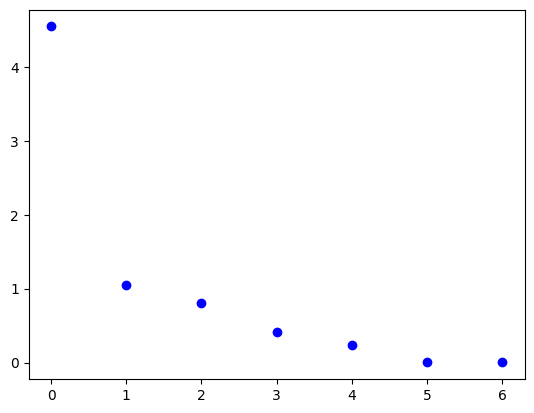

In [47]:
plt.plot(eigenvals, "bo")

#### Plot de genormaliseerde eigenwaarden

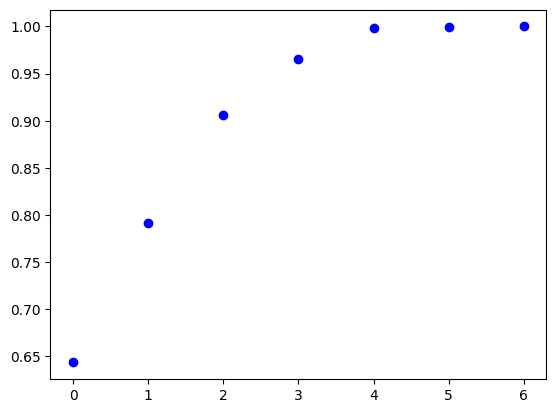

In [48]:
plt.plot(np.cumsum(eigenvals) / sum(eigenvals), 'bo')

hierbij kunnen we met de elleboog strategie zien dat de PC waarschijnlijk 2 is 

#### Vermenigvuldigen van de features met de eigen vectoren om de Principle Components te krijgen

In [49]:
PC = PCA_features.to_numpy() @ eigenvecs

In [50]:
PC = PC[:, :2]
PC.shape

(105, 2)

In [51]:
PC

array([[ 1.71190908e-01,  9.41279736e-01],
       [ 2.12568024e+00,  5.83653171e-01],
       [-1.02558081e+00, -1.37452800e+00],
       [ 3.73802767e-01,  5.75576180e-01],
       [-4.10270483e+00, -7.32262633e-01],
       [-1.16492464e+00,  3.44082761e-02],
       [ 6.07140615e-01, -7.79942184e-01],
       [ 1.52817658e+00, -7.82593730e-02],
       [-3.00144015e+00, -5.21488830e-01],
       [-1.23795072e+00,  1.56025447e+00],
       [ 1.09993992e+00, -9.47105269e-01],
       [ 1.21863791e+00,  1.82394835e+00],
       [-3.62288654e+00, -1.68291568e-01],
       [ 2.87267372e+00, -3.10208930e-01],
       [ 1.86963003e+00, -7.61361239e-01],
       [ 1.14114581e+00,  3.87605252e-02],
       [ 3.36338847e-01,  1.85668977e+00],
       [-4.22438788e+00, -4.16851266e-01],
       [-4.02437314e-01,  1.69381168e+00],
       [ 1.41756858e+00, -1.54468123e-01],
       [ 2.91608833e+00, -3.21673413e-01],
       [ 2.50556850e+00,  1.65350424e+00],
       [-8.84721699e-01,  2.01327793e-01],
       [-6.

#### Scatterplot van de PCA-Componenten


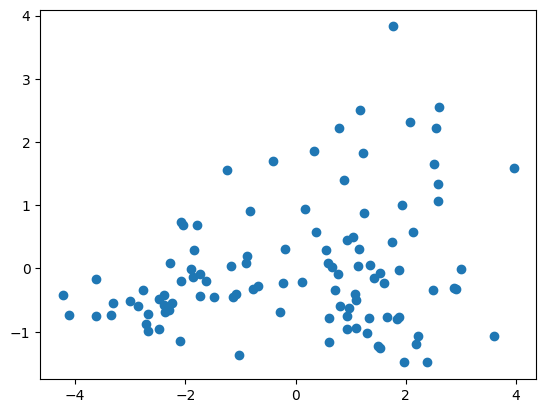

In [52]:
plt.scatter(PC[:,0],PC[:,1])

In de scatterplot kun je ongeveer 2 of 3 clusters zien. De groepen datapunten zijn redelijk duidelijk te zien

### Clusteren op de PCA features

Hier doen we de silhouette score berekenen van verschillende aantal clusters, de silhoutte score meet hoe dicht data punten bij elkaar liggen en dus kiezen we het aantal clusters waarbij de silhoutte score het hoogste is

C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

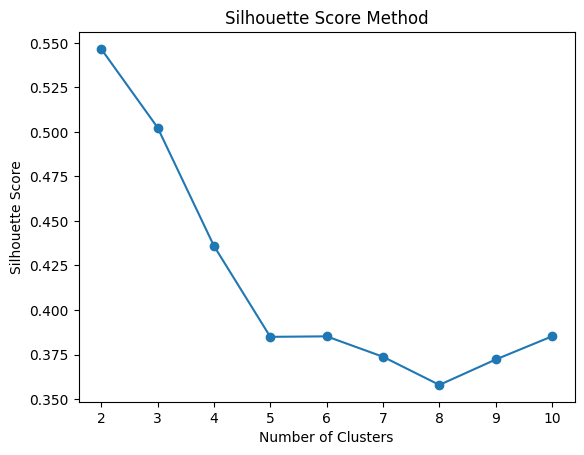

In [53]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(PC[:, :2])
    silhouette_scores.append(silhouette_score(PC[:, :2], labels))

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


Hier kiezen we er dus voor om 2 clusters te gebruiken doordat we in het eerste scatterplotje zelf vonden dat er 2 of 3 clusters aanwezig waren, en in de silhouette score zien we dat 2 de hoogste score heeft ook gaan we nog even kijken naar hoe de inertia's liggen

C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

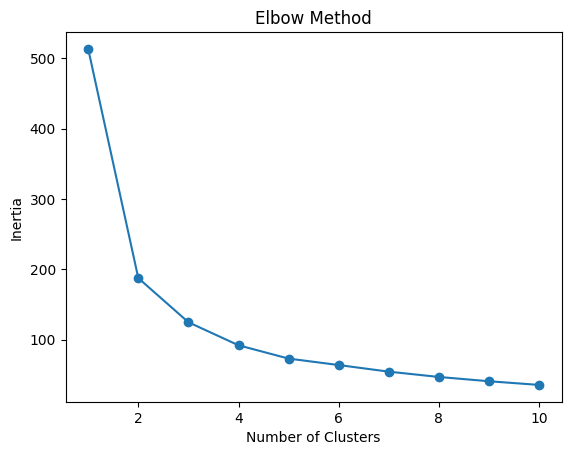

In [54]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(PC[:, :2])
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


Hier met nog een test zien we dat we 2 clusters hebben bij de Principle components

C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


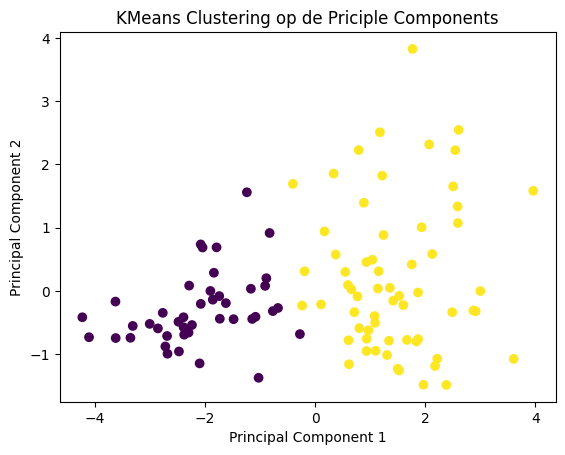

In [55]:
kmeans = KMeans(n_clusters=2)

# Voer de KMeans-clustering uit op de geselecteerde principale componenten
kmeans.fit(PC[:, :2])

# Krijg de toegewezen clusters voor elke datapunt
labels = kmeans.labels_

# Visualiseer de resultaten (optioneel)
plt.scatter(PC[:, 0], PC[:, 1], c=labels, cmap='viridis')
plt.title('KMeans Clustering op de Priciple Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


En hier gaan we de scatterplot laten zien met de werkelijke hoeveelheid clusters die zitten in de "features dataset"

C:\Users\KaasT\anaconda3\envs\librosa\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


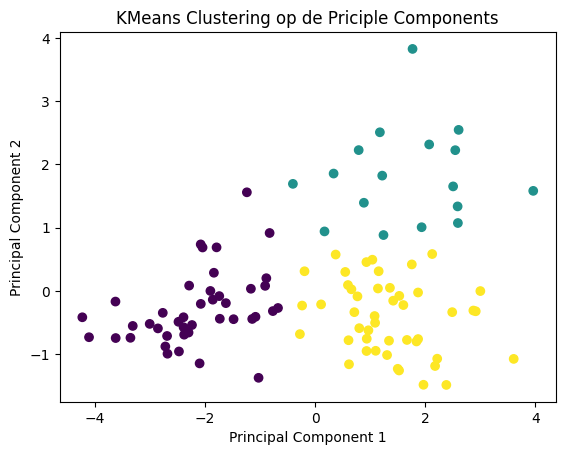

In [56]:
kmeans = KMeans(n_clusters=3)

# Voer de KMeans-clustering uit op de geselecteerde principale componenten
kmeans.fit(PC[:, :2])

# Krijg de toegewezen clusters voor elke datapunt
labels = kmeans.labels_

# Visualiseer de resultaten (optioneel)
plt.scatter(PC[:, 0], PC[:, 1], c=labels, cmap='viridis')
plt.title('KMeans Clustering op de Priciple Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Laten we de Cluster numbers van de PCA elementen toevoegen aan het dataframe met de Cluster nummers van onze 8 features en kijken of ze overeen komen

In [92]:
features_voor_vergelijking["Cluster_Number_PCA"] = list(labels)
with pd.option_context('display.max_rows', None):
    display(features_voor_vergelijking)

mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00003.wav   2.423996     2070.908729     2254.451748  0.120308  0.105834   
m00012.wav   5.791912     2286.246872     2908.260266  0.178373  0.146556   
m00013.wav  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
m00043.wav   0.310461     2073.302486     2384.812610  0.126274  0.110329   
m00044.wav -18.537571      899.979779      790.478225  0.052168  0.049446   
m00055.wav   4.526391     2421.110677     1901.411646  0.066257  0.061867   
m00061.wav  -0.359688     2268.080047     2644.879746  0.141872  0.121744   
m00063.wav  -0.154850     2522.727059     2939.529800  0.168612  0.140182   
m00069.wav -16.663797     1502.891671     1281.814379  0.059521  0.055978   
m00074.wav  -0.051628     1554.818602     1465.595383  0.088020  0.080272   
m00107.wav  -0.177516     2758.396869     2964.569477  0.140801  0.120976   
m00114.wav   5.349232     3220.089949     3149.971131  0.127601  0.111319   
m00127.wav -14.452309     1617.435431      973.554796  0.031578  0.030581   
m00137.wav   2.268721     3170.858348     3594.167118  0.185421  0.151040   
m00139.wav   0.752257     2930.999781     3262.912445  0.155364  0.131226   
m00148.wav   0.734711     3201.019548     2928.650383  0.105844  0.094641   
m00149.wav   5.048511     2231.750528     2375.553539  0.108103  0.096417   
m00156.wav -21.571781     1030.602431      715.477296  0.041342  0.039633   
m00183.wav   6.579768     1929.573768     2029.838780  0.100184  0.090148   
m00211.wav  -0.565280     2250.775398     2792.690281  0.162745  0.136259   
m00218.wav   2.854071     3271.662762     3889.787117  0.191237  0.154665   
m00228.wav   3.656099     3134.284752     3634.106564  0.183297  0.149699   
m00247.wav  -1.264886     2065.260133     2090.459458  0.093432  0.084702   
m00254.wav   2.851408     2062.531335     2099.350208  0.088372  0.080562   
m00266.wav  -6.699692     1558.487692     1431.542306  0.075320  0.069647   
m00289.wav   1.538458     2194.487062     2709.540066  0.166756  0.138948   
m00292.wav  -8.498735     1572.522989     1360.000106  0.072245  0.067026   
m00293.wav   8.163532     2227.706039     2410.986412  0.128485  0.111977   
m00309.wav  -6.811362     1438.824668     1807.430914  0.131149  0.113949   
m00318.wav   5.663175     2408.617500     2566.910608  0.125341  0.109631   
m00321.wav   2.070003     2848.670626     2526.130443  0.103660  0.092914   
m00323.wav   0.162670     1607.525214     1712.466256  0.116419  0.102865   
m00324.wav  -9.799267     1171.747322      901.785688  0.053507  0.050644   
m00331.wav  -7.801135     1367.107711     1211.215119  0.068540  0.063842   
m00348.wav  -1.562591     2573.214409     3237.576393  0.198375  0.159022   
m00355.wav   5.090476     3342.364414     4037.153771  0.214243  0.168343   
m00356.wav   6.719685     2208.673920     2716.833175  0.162425  0.136043   
m00357.wav   3.789764     3039.105673     2842.660793  0.125173  0.109505   
m00359.wav   4.639557     2205.638269     2751.926423  0.166960  0.139084   
m00363.wav  -1.089653     2683.946957     2518.668012  0.100342  0.090273   
m00371.wav   7.269338     3276.411253     3662.926659  0.156299  0.131870   
m00372.wav   4.514593     2102.978888     2442.670003  0.150036  0.127525   
m00391.wav   4.530478     2497.656043     2848.182022  0.144290  0.123471   
m00393.wav   4.139132     3175.666951     3301.864703  0.144646  0.123723   
m00399.wav  -0.680408     3001.708559     3142.253258  0.136612  0.117949   
m00405.wav   3.633015     3293.728176     3759.808973  0.177868  0.146231   
m00414.wav -12.017561     1525.255383     1396.692427  0.072723  0.067434   
m00434.wav  -9.153802     1578.592597     1558.898532  0.092330  0.083805   
m00463.wav -15.381470     1412.178906     1181.512556  0.071811  0.066654   
m00468.wav  -9.759991     1480.584417     1137.952953  0.081971  0.075252   
m00487.w

In [93]:
display(features_voor_vergelijking["Cluster_Number"].value_counts().to_frame())
display(features_voor_vergelijking["Cluster_Number_PCA"].value_counts().to_frame())

count
Cluster_Number       
1                  37
0                  37
2                  31

count
Cluster_Number_PCA       
2                      46
1                      42
0                      17

In [94]:
cluster_genre_dict = guess_categories(features['Cluster_Number'], ant['genre'].tolist())
features['Cluster_Number'] = translate_clusters(cluster_genre_dict, features['Cluster_Number'])

cluster_genre_dict = guess_categories(features['Cluster_Number_PCA'], ant['genre'].tolist())
features['Cluster_Number_PCA'] = translate_clusters(cluster_genre_dict, features['Cluster_Number_PCA'])

features

C:\Users\KaasT\AppData\Local\Temp\ipykernel_13800\1485818732.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster = cluster_list[i]


mfcc_mean  mean_bandwidth  mean_centroids       ZCR       ZCV  \
name                                                                        
m00003.wav   2.423996     2070.908729     2254.451748  0.120308  0.105834   
m00012.wav   5.791912     2286.246872     2908.260266  0.178373  0.146556   
m00013.wav  -7.811633     1865.851544     1953.012399  0.123587  0.108313   
m00043.wav   0.310461     2073.302486     2384.812610  0.126274  0.110329   
m00044.wav -18.537571      899.979779      790.478225  0.052168  0.049446   
...               ...             ...             ...       ...       ...   
m00971.wav -10.473551     1588.161024     1525.601267  0.091711  0.083300   
m00973.wav   5.705091     3295.553789     3671.260488  0.162033  0.135778   
m00988.wav   0.526684     3361.504206     3940.349921  0.167811  0.139650   
m00991.wav  -9.479113     1404.132189      983.761841  0.044275  0.042315   
m00995.wav  -6.416987     1371.336609     1253.132223  0.071732  0.066587   

            harmonic_number       tempo  l_prob_classical Cluster_Number  \
name                                                                       
m00003.wav         0.087392  132.512019             False          metal   
m00012.wav         0.060788  139.674831             False          metal   
m00013.wav         0.005412   97.508844              True      classical   
m00043.wav         0.057350  139.674831             False          metal   
m00044.wav         0.007238  117.453835              True      classical   
...                     ...         ...               ...            ...   
m00971.wav         0.000240  107.666016              True      classical   
m00973.wav         0.114283  129.199219             False            pop   
m00988.wav         0.000038  105.468750             False            pop   
m00991.wav         0.001587  117.453835              True      classical   
m00995.wav         0.028202  101.332721              True      classical   

           Cluster_Number_PCA  
name                           
m00003.wav              metal  
m00012.wav              metal  
m00013.wav          classical  
m00043.wav              metal  
m00044.wav          classical  
...                       ...  
m00971.wav          classical  
m00973.wav                pop  
m00988.wav              metal  
m00991.wav          classical  
m00995.wav          classical  

[105 rows x 10 columns]

In [96]:
def upload_kaggle_pca():
    antwoord = features.copy()
    antwoord = pd.DataFrame(columns=['filename','genre'])
    antwoord['filename'] = wav_names
    antwoord['genre'] = list(features['Cluster_Number_PCA'])
    antwoord = antwoord.set_index('filename')
    display(antwoord)
    return antwoord

upload_kaggle_pca().to_csv('poging_pca.csv')

genre
filename             
m00003.wav      metal
m00012.wav      metal
m00013.wav  classical
m00043.wav      metal
m00044.wav  classical
...               ...
m00971.wav  classical
m00973.wav        pop
m00988.wav      metal
m00991.wav  classical
m00995.wav  classical

[105 rows x 1 columns]

#### Conclusie PCA:
We hebben de PCA componenten vastgesteld dat het er 2 waren. Daarna gekeken naar hoeveel clusters er zitten met de PCA data. Dit liet ons zien dat er maar 2 clusters waren wat niet helemaal correct was met de werkelijke aantal clusters die we hebben in de data. Daarna hebben we Kmeans clustering uitgevoerd op zowel 2 en 3 clusters. Daar zagen we dat met het invoeren van 3 clusters we nogsteeds een uitstekende verdeling hadden van clusters. Wij vinden zelf dat de verdeling beter is bij 3 dan 2 clusters.

Daarnaast hebben we de clusters vergeleken met hoe ze eruit zagen voordat we de PCA componenten hadden gemaakt en zien we eigenlijk een erg interessant resultaat. De PCA clusters hebbveeln 6 verschillende datapunten met de clusters die we kregen uit de dataset met de 8 geluids-featureNa het testen op kaggle hebben wij een score van 0.69811. Het is te verklaren dat met PCA de score minder is dan zonder PCA. Dit komt doordat PCA de dataset versimpeld waardoor er data verloren gaat. Wij zijn tot de conclusie gekomen dat Dimensionality reduction niet goed heeft gewerkt voor ons project. De clusters zijn erg verschillend en de kaggle score is er erg op achteruitgegaan.re?

## Eenvoudig rekenvoorbeeld PCA
Nu we hebben vastgesteld dat PCA het opnieuw vormen van features betekent, waarbij ze worden gerangschikt op basis van hoe belangrijk ze zijn (Visually Explained. 2021, September 20), is het tijd voor een simpel rekenvoorbeeld. Hieronder volgt een stappenplan.

##### Stap 1: Standaardiseer de dataset
Laten we als voorbeeld deze dataset nemen:

[[1, 5, 8],

 [2, 5, 4],
 
 [5, 4, 7]]
 
Dan moeten we de dataset standaardiseren. Dat houdt in dat we het gemiddelde en de standaardafwijking nemen van de features, dus van de kolommen van de dataset.

Daar komt het volgende uit:

Gemiddelde: [2.66666667, 4.66666667, 6.33333333]
Standaardafwijking: [1.69967317, 0.47140452, 1.24721913]

Dan reken je voor alle waarden de nieuwe matrix-waarden uit met de standaardiseerformule

$x_{\text{new}} = \frac{{x - \mu}}{{\sigma}} $


$μ$ = het gemiddelde van de feature.

$σ$ = de standaardafwijking van de feature.



Voor de eerste feature wordt de gestandaardiseerde waarde dan:
$x_{\text{new}} = \frac{{1 - 2.66666667}}{{1.69967317}} = -0.98058068  $  



Wanneer die berekening voor alle matrix-waarden is gedaan, ziet de matrix er als volgt uit:


[[-0.98058068  0.70710678  0.98058068],

 [-0.39223227  0.70710678 -1.37281295],
 
 [ 1.37281295 -1.41421356  0.39223227]]





##### Stap 2: Bereken de covariance matrix voor alle features


$ \text{cov}(x, y) = \frac{1}{N-1} \sum_{i=1}^{N} (x_i - \bar{x}) \cdot (y_i - \bar{y})$




$\bar{x}$ en $\bar{y}$ zijn de gemiddelden van $x$ en $y$


$N$ is het aantal waarnemingen.$


Dan krijg je als uitkomst de volgende covariance matrix:


[[ 1.5        -1.45608802  0.05769231],

 [-1.45608802  1.5        -0.41602515],
 
 [ 0.05769231 -0.41602515  1.5       ]]



##### Stap 3: Bereken de eigenvalues en de eigenvectors van de covariance matrix

Een eigenvalue is een verandering in de lengte van een vector en wordt aangegeven met de letter lambda $λ$. De eigenvector is de veranderde vector die een lengte-transformatie heeft ondergaan, maar niet van richting is veranderd en wordt aangeduid met de letter $v$ . 
De formule is als volgt:


$\text{Cov} \cdot \mathbf{v} = \lambda \cdot \mathbf{v}$


(Wikipedia. Eigenvalues and eigenvectors. (n.d.).)

Er komt het volgende uit:


Eigenwaarden:

[ 3.03044707e+00 -3.60822483e-16  1.46955293e+00]


Eigenvectoren:

[[-0.67718737  0.6829112  -0.27395173], 

 [ 0.70318476  0.71027059  0.03235571],
 
 [-0.21667593  0.1707278   0.96119902]]





##### Stap 4: Sorteer de eigenvalues en de bijbehorende eigenvectors.

We sorteren ze op aflopende volgorde.
Dit komt eruit:


Gesorteerde Eigenwaarden:


[ 3.03044707e+00  1.46955293e+00 -3.60822483e-16]



Gesorteerde Eigenvectoren:


[[-0.67718737 -0.27395173  0.6829112 ],

 [ 0.70318476  0.03235571  0.71027059],
 
 [-0.21667593  0.96119902  0.1707278 ]]



##### Stap 5: Kies k eigenvalues uit en vorm een matrix van eigenvectors.


Als je bijvoorbeeld van de 3 dimensies die er nu zijn, er nog maar 2 wil overhouden, dan kies je voor k het getal 2. Deze matrix blijft dan over:


[[-0.67718737 -0.27395173]


 [ 0.70318476  0.03235571]
 
 
 [-0.21667593  0.96119902]]
 
 
 

##### Stap 6: Transformeer de oorspronkelijke matrix.


Vermenigvuldig hierbij de oorspronkelijke dataset met de eigenvectoren uit stap 5.

[[ 1.10532897  7.57741899],


 [ 1.29484532  3.45867118],
 
 
 [-2.08992935  5.48805735]]



# Conclusie

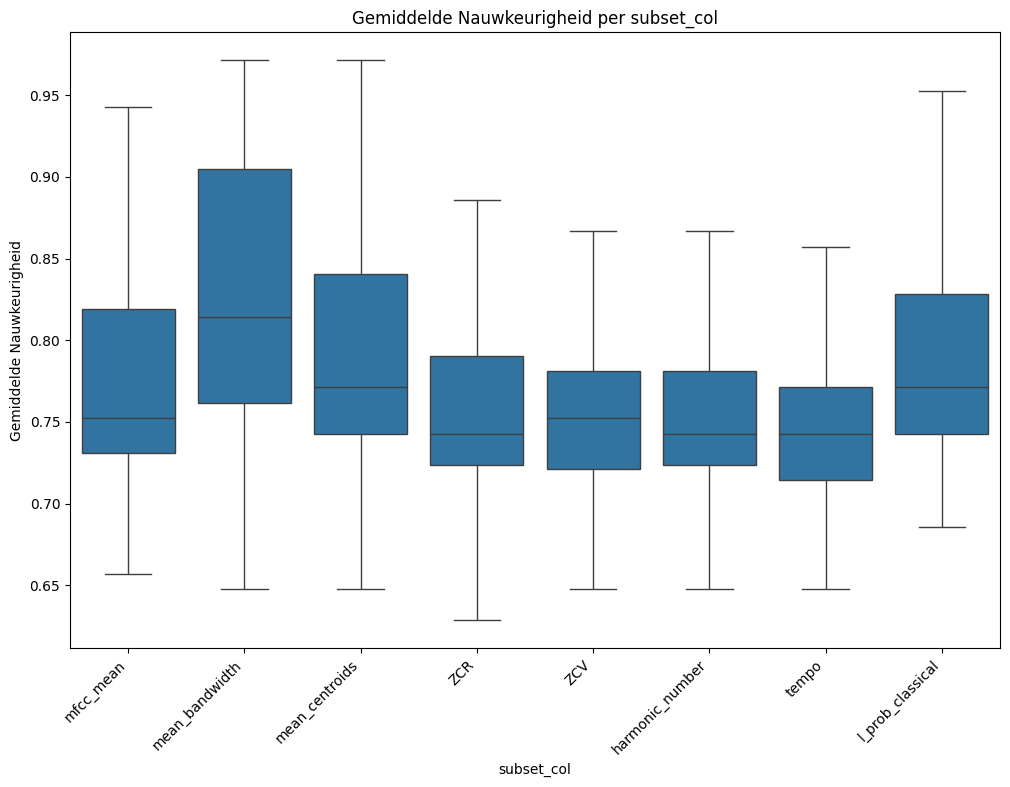

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Veronderstel dat df3 je DataFrame is

# Split de waarden in subset_col zodat elke waarde een aparte rij wordt
df3_expanded = df_3.explode('subset_col')

# Maak een boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='subset_col', y='accuracy', data=df3_expanded, showfliers=False)  # showfliers=False om uitbijters te verbergen
plt.title('Gemiddelde Nauwkeurigheid per subset_col')
plt.xlabel('subset_col')
plt.ylabel('Gemiddelde Nauwkeurigheid')
plt.xticks(rotation=45, ha='right')  # Om de x-as labels beter leesbaar te maken
plt.show()

Hier boven kan je zien wat voor ons de belangrijkste features waren. Mean_brandwith steek er bij ons met kop en schouders boven uit maar ook l_prob_classical en mean_centroids zijn erg nuttig.

Beschrijf het effect en nut van “dimensionality reduction”.

 

Dimensionality reduction hebben wij toegepast bij het stuk PCA (Principal Component Analysis). Dit zorgt ervoor dat je het hoeveelheid features verminderd in een dataset. Dit verminderd de complexiteit van de dataset en helpt met het voorkomen van overfitting. Dimensionality reduction streeft naar het behoud van de essentiële features en haalt de minder belangrijke informatie eruit. Met doel om ruis te verminderen waardoor het voor de data makkelijker zou zijn om patronenen te herkennen 

 

Beschrijf welke gegevens je nog meer zou willen hebben om nog betere aanbevelingen te kunnen doen? 

Hierbij  een simpele uitspraak “Massa is Kassa”. De meer muziek data die we hadden gekregen helpt ons ook met het verbeteren van de accuraatheid van de clusters. Als we meer muziek clips hadden om te bestuderen hadden we meer mogelijkheid om achter te komen wat de verschillen zijn tussen de genres en welke features daar het meeste invloed op hebben. 

Ook had het misschien geholpen om langere duratie te hebben per audio clip. Dit denken wij wel dat een minder belangrijke factor is dan meer data. Maar de langer dat de audio clip is de meer informatie die je kan op doen over het liedje en het patroon dat de meeste liedjes zouden hebben in die genre.

Wij denken makkelijk gezegd dat het toevoegen van meer nummers en tijd vergroten van de nummers (eigenlijk dus meer data) over de nummers. Zodat het potentieel makkelijker is om patrone
n te herkennen
Als dat mogelijk zou zijn, zouden wij graag nog de beschikking hebben over de volgende features:  de lyrics, de instrumenten en de lengte van de nummers. Wij denken dat we hier ook veel informatie uit zouden kunnen halen. Bij een heel lang nummer van meer dan 10 minuten zouden we ons kunnen voorstellen dat "klassiek" dan voorspeld zou kunnen worden. En bij boze lyrics zou het misschien wel metal kunnen zijn. Klassieke instrumenten zouden we kunnen herleiden tot klassieke muziek. Ook denken wij dat een grotere dataset de voorspellingen nog een stuk nauwkeuriger zou kunnen maken.

# Bronnenlijst

Audacity Team. (z.d.). Sample Rates. Audacity Manual. Geraadpleegd op 20 januari 2024, van https://manual.audacityteam.org/man/sample_rates.html

iZotope. (2020, april 3). Understanding Spectrograms. Geraadpleegd op 17 december 2023, van https://www.izotope.com/en/learn/understanding-spectrograms.html

LibROSA. (z.d.). Glossary. LibROSA Documentation. Geraadpleegd op 10 januari 2024, van https://librosa.org/doc/main/glossary.html

librosa development team. (2023). Onset detection. Retrieved December 17, 2023, from https://librosa.org/doc/0.10.1/onset.html

Librosa. (z.d.). librosa.stft. Librosa Documentation. Geraadpleegd op 10 januari 2024, van https://librosa.org/doc/main/generated/librosa.stft.html

MrAudioSoundImages. (2017, May 24). Zero Crossing and DC Offset [Video]. YouTube. https://www.youtube.com/watch?v=Dsm6Cs-8u0w


NumPy. (n.d.). numpy.var. Retrieved [datum] from https://numpy.org/doc/stable/reference/generated/numpy.var.html

OpenAI 1. (2023, december 17). ChatGPT Discussie. OpenAI. https://chat.openai.com/c/67af1d21-8ccd-4ecf-8b66-b36d7f935131

Shkhanukova, M. (2022, september 15). Choose N_FFT for Spectrograms, FFT. Medium. https://medium.com/@milana.shxanukova15/n-fft-parameter-in-fft-134712e1c79d



PyTorch. (z.d.). torch.stft. PyTorch Documentation. Geraadpleegd op 15 januari 2024, van https://pytorch.org/docs/stable/generated/torch.stft.html


Wikipedia. (z.d.). 44,100 Hz. Wikipedia. Geraadpleegd op 15 december 2023, van https://en.wikipedia.org/wiki/44,100_Hz

Wikipedia. (2023, December 16). Zero-crossing rate. In Wikipedia. Retrieved December 16, 2023, from https://en.wikipedia.org/wiki/Zero-crossing_rate


The Nobles. (2020, January 7). Understanding Principle Component Analysis (PCA) step by step. Analytics Vidhya. https://medium.com/analytics-vidhya/understanding-principle-component-analysis-pca-step-by-step-e7a4bb4031d9

Visually Explained. (2021, September 29). Principal Component Analysis (PCA) Visually Explained [Video]. YouTube. https://www.youtube.com/watch?v=FD4DeN81ODY

Wikipedia. Eigenvalues and eigenvectors. (n.d.). In Simple English Wikipedia. Retrieved January 10 2024, from https://simple.wikipedia.org/wiki/Eigenvalues_and_eigenvectors

Codecademy Team. (n.d.). Normalization. Codecademy. Retrieved January 15 2024, from https://www.codecademy.com/article/normalization

Varasteh, A. (2020, March 26). Non-Negative Matrix Factorization (NMF) | Multiplicative Update Rules By Lee And Seung [Video]. YouTube. https://www.youtube.com/watch?v=o4pPTwsd-5M

Wikipedia. Non-negative matrix factorization. (n.d.). In Wikipedia. Retrieved January 14 2024, from https://en.wikipedia.org/wiki/Non-negative_matrix_factorization

OpenAI. (21 januari 2024). Frobenius-norm berekening met NMF. ChatGPT., from https://chat.openai.com/c/ba92d3bd-5f90-4c23-9adc-920f4bd9f631